# Training & test on Resisc45, S2 cloudless and mixed data sets

## Train summary
* train the U-Net, (1) separatelly, S2 and Resisc45 image data sets and (2) on mixed s2 + Resisc45 data set on both 256x256 and 512x512 image resolutions 
* testing or evaluating the model was done from (1) the same data set (2) from both data sets for the mixed data set and (3) on the other data set.
* instead of keras `ImaageDataGenerator` I've used the TensorFlow 2.x DataSet API that uses eager execution so the images were transformed into Tensor objects
* The implemented data augmentation includes: random rotations at 90 degree, and random flip
* since is necessary to have a threshold for the _water pixel_ values in the
predicted masks, each training session has its own value
* The S2 data set contains 90 images and the Resisc45 contain 70 images
* Each data set is split into train, validation and test data sets, with more than ~80% of the images are used for training
* Since both data sets are pretty small I've used the `.repeat()` API in order to accommodate the train steps and the batch count

Some training results:

`[Data set (train/test)]`  				|  `[#]` | `[Image size]` | `[Water pixel value]` | `[Train epochs]` | `[Test loss]` | `[Test acc (mean-IoU)]`
:-| -: | -: | -: | -: | -: | -:
resisc45 	| 70 | 256| 60  | 500 |37% | 40%
resisc45 	| 70 | 256| 100 | 500 |28% | 50%
resisc45 	| 70 | 256| 120 | 1000 |45% | 30%
resisc45 	| 70 | 256| 100 | 1000 |36% | 48%
resisc45 	| 70 | 256| 100 | 700 |46% | 37%
resisc45 	| 70 | 256| 90 | 300 |21% | 25%
resisc45 	| 70 | 256| 80 | 300 |21% | 58%
s2 		 	| 90 | 512| 60  | 100 | 6% | 50%
s2       	| 90 | 512| 100 | 100 | 8% | 100%
s2       	| 90 | 512| 60  | 300 | 3% | 100%
mixed    	|160 | 512| 60  | 100 | 13%|  26%
mixed    	|160 | 512| 60  | 300 | 20%|  17%
mixed    	|160 | 512| 100 | 100 | 13%|  12%
mixed    	|160 | 256| 60 | 300 | 16%|  31%
mixed    	|160 | 256| 100 | 300 | 10%|  44%
mixed    	|160 | 256| 100 | 600 | 39%|  42%
resisc45/s2 |70 | 256| 60  | 500 | 79%|  10%
resisc45/s2 |70 | 256| 100  | 500 | 51%|  34%
resisc45/s2 |70 | 256| 100  | 500 | 51%|  33%
s2/resisc45 |90 | 512| 60  | 200 | 57%|  4%

### Conclusions
* the model log history shows that loss is decreasing with the number of epochs which is expected
* the chaotic values for mean IoU can be a sign that the learning rate is to high or the mean-IoU function must be fine tuned
* on intermediary steps at the end of epoch, the model predicts the water mask  pretty well but `evaluating` entire on the test data set it performs mediocre with accuracy ~50% or less on Resisc45 data set
* using mixed s2 + resisc45 data sets doesn't result in a better model as test loss is pretty high, up to 39%
* training on a data set source and testing on the other results in worse test
performace with high loss values and low accuracy
* looks like a _water pixel_ threshold of about `100` means better accuracy and it should be tuned based on the _water pixel_ values
* the best and stable fit is obtained on the S2 (512x512 image size) data set with low test loss and high accuracy (IoU)
* resisc45 data set performed suboptimal on all tries regarless of the number of train epoch and _water pixel_ value

In [3]:
from google.colab import drive
import tarfile

def extract_dataset_archive(archive_file, output_dir):
    with tarfile.open(archive_file, mode = 'r:gz') as tar:
        tar.extractall(output_dir)

resisc_data_dir = 'resisc_imagery'
resisc_data_archive = 'resisc_dataset.tar.gz'

s2_data_dir = 's2_imagery'
s2_data_archive = 's2_dataset.tar.gz'

drive.mount('/content/drive')
!cp '/content/drive/My Drive/data_sets/$resisc_data_archive' . -vf
!cp '/content/drive/My Drive/data_sets/$s2_data_archive' . -vf

extract_dataset_archive(resisc_data_archive, resisc_data_dir)
extract_dataset_archive(s2_data_archive, s2_data_dir)

!ls

Mounted at /content/drive
'/content/drive/My Drive/data_sets/resisc_dataset.tar.gz' -> './resisc_dataset.tar.gz'
'/content/drive/My Drive/data_sets/s2_dataset.tar.gz' -> './s2_dataset.tar.gz'
drive		       resisc_imagery	  s2_imagery
resisc_dataset.tar.gz  s2_dataset.tar.gz  sample_data


Define data set utilities
> split images and masks into train, validation and test data sets

> data set loader class that returns batches of tensor pairs for image and mask




In [1]:
import tensorflow as tf
#import tensorflow_addons as tfa
import numpy as np
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image
import shutil, glob, json, os, time
import pathlib
import random

#import tensorflow_addons as tfa
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_image_paths(working_data_dir = 'train_dataset'):
    mask_paths = []
    image_paths = []

    for file in glob.glob(working_data_dir + os.sep + 'images' + os.sep + '*.jpg'):
        mask_file = working_data_dir + os.sep + 'masks' + os.sep + to_mask_file_name(file)
        if (os.path.exists(mask_file)):
            mask_paths.append(mask_file)
            image_paths.append(file)

    print('load {} images'.format(len(mask_paths)))
    return image_paths, mask_paths

def load_image_paths2(imagery_dir = 's2cloudless_imagery', imagery_label_dir = 's2cloudless_label_imagery',
                      ):
    mask_paths = []
    image_paths = []

    for file in glob.glob(imagery_dir + os.sep + 'data' + os.sep + '*.jpg'):
        mask_file = imagery_label_dir + os.sep + 'data' + os.sep + os.path.basename(file) + '_mask.jpg'
        # print('load file mask: {}'.format(mask_file))
        if (os.path.exists(mask_file)):
            mask_paths.append(mask_file)
            image_paths.append(file)

    print('load {} images'.format(len(mask_paths)))

    return image_paths, mask_paths

def to_mask_file_name(file_name):
    file_name = os.path.basename(file_name)
    name, ext = os.path.splitext(file_name)
    return name + '_mask' + ext

def split_data_set(image_paths, mask_paths, split_ratios=(0.7, 0.15, 0.15)):
    if (sum(split_ratios) != 1.0):
      print("error, sum of ratios not equal to 1: {}".format(split_rations))
      return

    print("splitting data set images: {:.2f}% training / {:.2f}% validation \
/{:.2f}% test".format(split_ratios[0] * 100.0, split_ratios[1] * 
                                100.0, split_ratios[2] * 100.0))
    data_set = list(zip(image_paths, mask_paths))
    random.shuffle(data_set)

    split = int(split_ratios[0] * len(data_set))
    valsplit = int(split_ratios[1] * len(data_set))

    #split into training and testing
    train_files = data_set[0:split]
    val_files  = data_set[split:split+valsplit]
    test_files  = data_set[split+valsplit:]

    return train_files, val_files, test_files

class DataSetLoader(object):
    """ Creates a TensorFlow DataSet that can be used in image semantic segmentation  """
    def __init__(self, img_mask_paths_zip_list, image_size, channels=[3, 3]):
        # unzip the sequence
        self.image_paths, self.mask_paths = zip(*img_mask_paths_zip_list)
        self.image_paths = list(self.image_paths)
        self.mask_paths = list(self.mask_paths)
        print("DataSetLoader: load {} images".format(len(img_mask_paths_zip_list)))
        self.image_size = image_size
        self.channels = channels
        self.use_rotate = False
        # print (type(self.image_paths))

    def _normalize_img(self, image, mask):
        #image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        #mask = tf.image.convert_image_dtype(mask,  dtype=np.uint8)
        image = tf.cast(image, tf.float32) / 255.0
        #mask = tf.cast(mask, tf.uint8)
        mask = tf.reduce_max(mask, axis=2)
        # water pixels are always greater than 100
        mask = mask > 100
        mask = tf.cast(mask, tf.uint8)
        return image, mask

    def _resize_img(self, image, mask):
        image = tf.image.resize(image, self.image_size, method='nearest')
        mask = tf.image.resize(mask, self.image_size, method='nearest')
        return image, mask

    def _flip_img(self, image, mask):
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
        return image, mask

    def _rotate_img(self, image, mask):
        k = random.randint(0, 3)
        if k > 0:
          print("rotate by ", k * 90)
          image = tf.image.rot90(image, k)
          mask = tf.image.rot90(mask, k)
        else:
          print("no rotation")
        return image, mask

    def _decode_img(self, img_path, ch):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, self.channels[ch])
        return img

    def _load_img(self, image_path, mask_path):
        image = self._decode_img(image_path, 0)
        mask = self._decode_img(mask_path, 1)
        # convert mask to black-white image
        # mask = tf.image.rgb_to_grayscale(mask)
        return self._flip_img(image, mask)

    def data_batch(self, batch_size, shuffle=True):
        """ Converts input images into TensorFlow 2.0 numpy based DataSet """

        # Creates a Dataset whose elements are slices of the given tensors
        data = tf.data.Dataset.from_tensor_slices((self.image_paths, self.mask_paths))

        # Converts DataSet into Image/Mask DataSet
        data = data.map(self._load_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Resize images
        data = data.map(self._resize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Rotate images (before Normalize)
        data = data.map(self._rotate_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Normalize data
        data = data.map(self._normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Prefetch and batch data
        if shuffle:
            # Prefetch, shuffle and batch data
            data = data.prefetch(tf.data.experimental.AUTOTUNE) \
            .shuffle(len(self.image_paths)).batch(batch_size)
        else:
            data = data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        return data

""" Make dataset from (image, mask) zip list
"""
def make_data_set(img_mask_paths_zip_list, batch_size=8, img_size=256, channels=[3, 3]):
  if (len(img_mask_paths_zip_list) == 0):
    return None

  dataset = DataSetLoader(img_mask_paths_zip_list, image_size=(img_size, img_size),
                          channels=channels)

  dataset = dataset.data_batch(batch_size=batch_size)
  return dataset

""" Load images and masks from data directory, shuffles the image list and returns
    the training and test DataSet objects
"""
class ImageSegDataSetsLoader(object):
    def __init__(self, data_dirs, split_ds=(0.7, 0.15, 0.15), batch_size=8,
                 img_size=256, channels=[3, 3]):
      train_image_paths = []
      train_mask_paths = []

      if type(data_dirs) == str:
        data_dirs = [data_dirs]

      for dir in data_dirs:
        image_paths, mask_paths = load_image_paths(dir)
        train_image_paths.extend(image_paths)
        train_mask_paths.extend(mask_paths)

      # split data sets
      train_ds, val_ds, test_ds = split_data_set(train_image_paths,
                                                  train_mask_paths,
                                                  split_ratios=split_ds)

      self.train_steps = len(train_ds) // batch_size
      self.validation_steps = len(val_ds) // 1
      self.test_steps = len(test_ds) // 1
      print("ImageSegDataSetsLoader steps: train: ", self.train_steps,
            ", validation: ", self.validation_steps,
            ", test: ", self.test_steps)

      self.train_ds = make_data_set(train_ds, batch_size, img_size, channels)
      self.validation_ds = make_data_set(val_ds, batch_size, img_size, channels)
      self.test_ds  = make_data_set(test_ds, batch_size, img_size, channels)

In [4]:
resisc_data_sets = ImageSegDataSetsLoader(resisc_data_dir,
                                          img_size=256,
                                          split_ds=(0.76, .12, .12))

load 70 images
splitting data set images: 76.00% training / 12.00% validation /12.00% test
ImageSegDataSetsLoader steps: train:  6 , validation:  8 , test:  9
DataSetLoader: load 53 images
rotate by  270
DataSetLoader: load 8 images
no rotation
DataSetLoader: load 9 images
rotate by  270


How to enable tfa.image module

In [5]:
s2_data_sets = ImageSegDataSetsLoader(s2_data_dir, img_size=512, split_ds=(0.80, .1, .1))

load 90 images
splitting data set images: 80.00% training / 10.00% validation /10.00% test
ImageSegDataSetsLoader steps: train:  9 , validation:  9 , test:  9
DataSetLoader: load 72 images
rotate by  270
DataSetLoader: load 9 images
rotate by  180
DataSetLoader: load 9 images
rotate by  180


In [6]:
data_sets = ImageSegDataSetsLoader([resisc_data_dir, s2_data_dir], img_size=512, split_ds=(0.86, .07, .07))

load 70 images
load 90 images
splitting data set images: 86.00% training / 7.00% validation /7.00% test
ImageSegDataSetsLoader steps: train:  17 , validation:  11 , test:  12
DataSetLoader: load 137 images
rotate by  180
DataSetLoader: load 11 images
rotate by  270
DataSetLoader: load 12 images
rotate by  90


In [6]:
resisc_test_data_512_sets = ImageSegDataSetsLoader(resisc_data_dir, img_size=512, split_ds=(0., 0., 1.))

load 70 images
splitting data set images: 0.00% training / 0.00% validation /100.00% test
ImageSegDataSetsLoader steps: train:  0 , validation:  0 , test:  8
DataSetLoader: load 70 images
no rotation


In [7]:
resisc_train_data_sets = ImageSegDataSetsLoader(resisc_data_dir, img_size=256, split_ds=(.85, .15, 0.))

load 70 images
splitting data set images: 85.00% training / 15.00% validation /0.00% test
ImageSegDataSetsLoader steps: train:  7 , validation:  1 , test:  0
DataSetLoader: load 59 images
rotate by  180
DataSetLoader: load 10 images
rotate by  180
DataSetLoader: load 1 images
rotate by  270


In [8]:
s2_train_data_sets = ImageSegDataSetsLoader(s2_data_dir, img_size=512, split_ds=(.9, 0.1, 0.))

load 90 images
splitting data set images: 90.00% training / 10.00% validation /0.00% test
ImageSegDataSetsLoader steps: train:  10 , validation:  1 , test:  0
DataSetLoader: load 81 images
rotate by  90
DataSetLoader: load 9 images
no rotation


In [9]:
s2_test_data_256_sets = ImageSegDataSetsLoader(s2_data_dir, img_size=256, split_ds=(0., 0., 1.))

load 90 images
splitting data set images: 0.00% training / 0.00% validation /100.00% test
ImageSegDataSetsLoader steps: train:  0 , validation:  0 , test:  11
DataSetLoader: load 90 images
rotate by  270


In [17]:
data_sets_256 = ImageSegDataSetsLoader([resisc_data_dir, s2_data_dir], img_size=256, split_ds=(0.86, .07, .07))

load 70 images
load 90 images
splitting data set images: 86.00% training / 7.00% validation /7.00% test
ImageSegDataSetsLoader steps: train:  17 , validation:  1 , test:  1
DataSetLoader: load 137 images
rotate by  90
DataSetLoader: load 11 images
no rotation
DataSetLoader: load 12 images
no rotation


Unet and training utilities:
> SemSegEvaluator : evaluates the model

> PlotLearning : callback called after each epoch to record loss, validation loss, mean IoU and validation mean IoU and evaluate the model

> UnetSemanticSegmentation : helper class for building the Unet model, train , load weights and evaluate the model

In [27]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU as tf_MeanIoU

WATER_PIXEL_MIN_VALUE = 100
WATER_PIXEL_PROB = WATER_PIXEL_MIN_VALUE / 256.0

def set_min_water_pixel(min_water_pixel):
  WATER_PIXEL_PROB = min_water_pixel / 256.0
  print("set water pixel prob: ", WATER_PIXEL_PROB)

def print_bincount(comment, y_true):
  print(comment," zeros: ", tf.math.count_nonzero(tf.equal(y_true, 0)),
        ", ones: ", tf.math.count_nonzero(tf.equal(y_true, 1)),
        "bin_count: ", tf.math.bincount(tf.cast(y_true, dtype=tf.dtypes.int32)))

def mean_iou_other(y_true, y_pred, is_tensor=True):
  # print("~tensors: ", y_true, " / ", y_pred)
  # print_bincount("y_true: ", y_true)
  # print_bincount("y_pred: ", y_pred)

  if is_tensor :
    I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
    U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
  else :
    I = tf.reduce_sum(y_pred * y_true)
    U = tf.reduce_sum(y_pred + y_true) - I

  return tf.reduce_mean(I / U)

def mean_iou_tf(y_true, y_pred, is_tensor=True):
  print("tensors: ", y_true, " / ", y_pred)
  miou = tf_MeanIoU(num_classes=2)
  miou.reset_states()
  miou.update_state(y_true, y_true)
  print(miou.result())
  return miou.result()

""" Liveproject version """
def mean_iou(y_true, y_pred, is_tensor=True, debug=False):
  if debug :
    print("mean_iou_liveprj: ", y_true.shape, y_pred.shape)

  # binarize and make a float
  if is_tensor :
    yp0 = tf.cast(y_pred[:,:,0] > WATER_PIXEL_PROB, 'float32')
    yt0 = y_true[:,:,0]
  else :
    yp0 = y_pred
    yt0 = y_true

  if debug :
    # print("mean_iou_liveprj: ", yt0.shape, yp0.shape)
    print_bincount("y_true: ", y_true)
    print_bincount("y_pred: ", y_pred)

  # get the intersection (numerator in above equation) 
  inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))

  # get the union (denominator)
  union = tf.math.count_nonzero(tf.add(yt0, yp0))

  # compute iou as the ratio unless the denominator is zero
  return tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))

def histogram(x):
  y = np.bincount(x)
  ii = np.nonzero(y)[0]
  print(list(zip(ii,y[ii])))

""" Evaluates a model trained for semantic segmentation by computing
    the mean Intersection-Over-Union metric (mean-IOU) and ploting side-by-side
    the real image, the mask, the image * mask and the image * predicted mask.
    This can be done for all images in the test set or just for single random
    image.
    """
class SemSegEvaluator(object):
    def __init__(self, test_data_set):
      self.test_data_set = test_data_set

    def predict_and_show(self, unet_model=None, model=None, count=-1):
      # mean Intersect over Union
      miou = tf_MeanIoU(num_classes=2)

      test_model = None
      if unet_model != None:
        test_model = unet_model.model
      elif model != None:
        test_model = model

      for image_raw, mask_raw in self.test_data_set.take(count):
        # print("img: ", image_raw.shape, ", mask: ", mask_raw.shape)

        # trim batch count
        image_raw = image_raw[0,]
        mask_raw  = mask_raw[0,]

        # print("img: ", image_raw.shape, ", mask: ", mask_raw.shape)

        if test_model == None:
          mask_raw = np.stack((mask_raw,)*3, axis=-1)
          prod = image_raw * mask_raw
          print("pixel values, max:", tf.reduce_max(prod),
                "min: ", tf.reduce_min(prod),
                "mean: ", tf.reduce_mean(prod))
          prod_uint = tf.cast(256 * prod, tf.dtypes.int32)
          histogram(prod_uint.numpy().flatten())
          #print("bincount: ", tf.math.bincount(prod.numpy().flatten()))
          # print("img: ", image_raw.shape, ", mask: ", mask_raw.shape)
          combined = np.concatenate([image_raw, mask_raw, prod], axis = 1)
        else:
          # reshape test images/masks if required
          if unet_model != None and unet_model.model.image_shape != image_raw.shape:
            size = [unet_model.model.image_shape[0], unet_model.model.image_shape[1]]
            image_raw = tf.image.resize(image_raw, size, method='nearest')
            mask_raw = tf.image.resize(mask_raw, size, method='nearest')
            print("after resize img: ", image_raw.shape, ", mask: ", mask_raw.shape)

          # predict the mask 
          pred_mask = test_model.predict(np.expand_dims(image_raw, 0)).squeeze()
          print("pred_mask shape: ", pred_mask.shape, ", max_value: ", np.max(pred_mask))

          # convert water pixel probabilities to binary
          pred_mask[pred_mask >= WATER_PIXEL_PROB] = 1
          pred_mask[pred_mask < WATER_PIXEL_PROB] = 0

          # compute mean Intersect over Union using two methods
          print("[test_ds] mean-IoU: {:.2f}%".format(mean_iou(mask_raw, pred_mask, False, False).numpy() * 100.0))
          miou.reset_states()
          miou.update_state(mask_raw, pred_mask)
          print("[test_ds] tf-mean-IoU: {:.2f}%".format(miou.result().numpy() * 100.0))

          # mask post-processing 
          pred_mask = np.stack((pred_mask,) * 3, axis = -1)
          mask_raw = np.stack((mask_raw,)*3, axis=-1)
          # print("pred_mask shape: ", pred_mask.shape, ", max_value: ", np.max(pred_mask))

          # print ("image_raw * mask_raw ", image_raw * mask_raw)
          # print ("image_raw * pred_mask ", image_raw * pred_mask)

          combined = np.concatenate([image_raw,
                                     mask_raw,
                                     image_raw * mask_raw,
                                     image_raw * pred_mask],
                                    axis = 1)

        plt.axis('off')
        plt.imshow(combined)
        plt.show()

class PlotLearning(tf.keras.callbacks.Callback):
    def __init__(self, evaluator=None):
      self.evaluator = evaluator

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1

        print("epoch[{}] loss={}, val_loss={}, mean_iou={:.2f}%, val_mean_iou={:.2f}%"\
              .format(self.i, logs.get('loss'), logs.get('val_loss'),
                      logs.get('mean_iou') * 100.0, logs.get('val_mean_iou') * 100.0))
        # print("logs: ",logs)
        if (self.evaluator == None):
          return

        # predict and show mean IoU + plot predicted mask for a single random test image
        print("------- evaluate & plot ---------")
        self.evaluator.predict_and_show(model=self.model, count=1)
        print("----------------")

class UnetSemanticSegmentation():

    def __init__(self, image_shape=(256, 256, 3), hdf5_weight_file='unet.h5'):
      self.image_shape = image_shape
      self.hdf5_weight_file = hdf5_weight_file

      inputs = Input(image_shape)
      _ = inputs

      # down sampling 
      f = 8
      layers = []

      for i in range(0, 6):
        _ = Conv2D(f, 3, activation='relu', padding='same') (_)
        _ = Conv2D(f, 3, activation='relu', padding='same') (_)
        layers.append(_)
        _ = MaxPooling2D() (_)
        f = f*2

      ff2 = 64 

      # bottleneck 
      j = len(layers) - 1
      _ = Conv2D(f, 3, activation='relu', padding='same') (_)
      _ = Conv2D(f, 3, activation='relu', padding='same') (_)
      _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
      _ = Concatenate(axis=3)([_, layers[j]])
      j = j -1 

      # upsampling 
      for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        _ = Conv2D(f, 3, activation='relu', padding='same') (_)
        _ = Conv2D(f, 3, activation='relu', padding='same') (_)
        _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
        _ = Concatenate(axis=3)([_, layers[j]])
        j = j -1 

      # classification 
      _ = Conv2D(f, 3, activation='relu', padding='same') (_)
      _ = Conv2D(f, 3, activation='relu', padding='same') (_)
      outputs = Conv2D(1, 1, activation='sigmoid') (_)

      # model creation
      self.model = Model(inputs=[inputs], outputs=[outputs])
      # mean_iou = tf_MeanIoU(num_classes=2, name='mean_iou')
      self.model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
      self.hitory = None

    def train(self, data_sets, test_data_sets, num_epochs=100,
              save_path='unet.h5',
              show_predictions=True):
      # build train checkpointer
      checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=self.hdf5_weight_file,
                                                        verbose=0,
                                                        save_best_only=True,
                                                        save_weights_only=True)
      if show_predictions:
        evaluator = SemSegEvaluator(test_data_set = test_data_sets.test_ds)
      else:
        evaluator = None

      callbacks = [checkpointer, PlotLearning(evaluator = evaluator)]
        
      print("start training: epochs: ", num_epochs,
            ", steps: train: ", data_sets.train_steps,
            ", validation: ", data_sets.validation_steps,
            ", test: ", data_sets.test_steps)

      # Start model training. Use verbose = 0 because we have a callback function
      # that displays a test image and prediction at the end of each epoch
      self.history = self.model.fit(data_sets.train_ds.repeat(), epochs = num_epochs,
                               steps_per_epoch = data_sets.train_steps,
                               validation_data = data_sets.validation_ds.repeat(),
                               validation_steps = data_sets.validation_steps,
                               callbacks = callbacks,
                               verbose = 0, use_multiprocessing=True)

    def restore_weights(self, hdf5_weight_file=None):
      weights_file = self.hdf5_weight_file

      if (hdf5_weight_file != None):
        weights_file = self.hdf5_weight_file

      print("loading weights file: ", weights_file)
      self.model.load_weights(weights_file)

    def evaluate(self, data_sets=None, repeat_count=None):
      if repeat_count == None :
        results = self.model.evaluate(data_sets.test_ds)
      else :
        print("evaluate: test data set repeat count: ", repeat_count)
        results = self.model.evaluate(data_sets.test_ds.repeat(repeat_count))

      print("test loss, test acc:", results)

def train_evaluate(train_data_sets, test_data_sets, image_shape=(256, 256, 3),
                   num_epochs=200, eval_repeat_count=100, unet_h5='unet.h5',
                   min_water_pixel=100, show_predictions=False):
  unet_semseg = UnetSemanticSegmentation(image_shape=image_shape,
                                         hdf5_weight_file=unet_h5)
  set_min_water_pixel(min_water_pixel)
  unet_semseg.train(data_sets=train_data_sets,
                    test_data_sets=test_data_sets,
                    num_epochs=num_epochs,
                    show_predictions=show_predictions)
  # model.model.summary()
  unet_semseg.evaluate(data_sets=test_data_sets,
                       repeat_count=eval_repeat_count)
  # show 
  plt.figure(figsize=(10,10))
  plt.subplot(121)
  plt.plot(unet_semseg.history.history['mean_iou'],'k',lw=1) #plot the training iou curve
  plt.plot(unet_semseg.history.history['val_mean_iou'],'r',lw=1) #plot the testing iou curve
  plt.ylim(0,1) #put limits of y axis
  plt.axhline(y=0.85) #draw a horizontal line at 85% IoU
  plt.title('Model IoU') #add title, labels and a legend
  plt.ylabel('IoU')
  plt.xlabel('Epoch number')
  plt.legend(['train', 'test'], loc='upper left')

  plt.figure(figsize=(10,10))
  plt.subplot(121)
  plt.plot(unet_semseg.history.history['loss'],'k',lw=1)
  plt.plot(unet_semseg.history.history['val_loss'],'r',lw=1)
  plt.ylim(0,1)
  plt.axhline(y=0.05)
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch number')
  plt.legend(['train', 'test'], loc='upper left')


## Show water pixel value distribution range inside the mask

In [ ]:
segeval = SemSegEvaluator(data_sets.train_ds)
segeval.predict_and_show(count=2)

## Train different combinations

set water pixel prob:  0.390625
start training: epochs:  1000 , steps: train:  6 , validation:  1 , test:  1
epoch[1] loss=0.8048787117004395, val_loss=0.509914219379425, mean_iou=1.90%, val_mean_iou=2.39%
logs:  {'loss': 0.8048787117004395, 'mean_iou': 0.018964692950248718, 'val_loss': 0.509914219379425, 'val_mean_iou': 0.02392578125}
epoch[2] loss=0.4915904700756073, val_loss=0.45656073093414307, mean_iou=1.58%, val_mean_iou=3.34%
logs:  {'loss': 0.4915904700756073, 'mean_iou': 0.015845337882637978, 'val_loss': 0.45656073093414307, 'val_mean_iou': 0.033421751111745834}
epoch[3] loss=0.4418894350528717, val_loss=0.42728638648986816, mean_iou=4.21%, val_mean_iou=4.30%
logs:  {'loss': 0.4418894350528717, 'mean_iou': 0.04209982231259346, 'val_loss': 0.42728638648986816, 'val_mean_iou': 0.04296160861849785}
epoch[4] loss=0.5071033239364624, val_loss=0.4232971966266632, mean_iou=2.82%, val_mean_iou=3.29%
logs:  {'loss': 0.5071033239364624, 'mean_iou': 0.028189068660140038, 'val_loss': 0.42

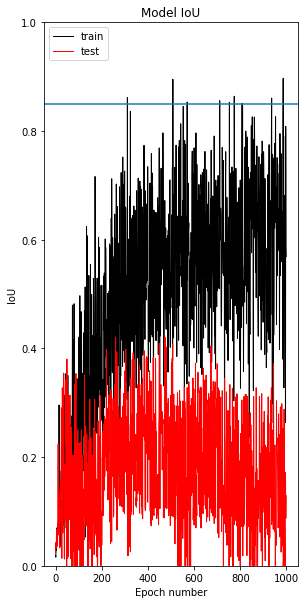

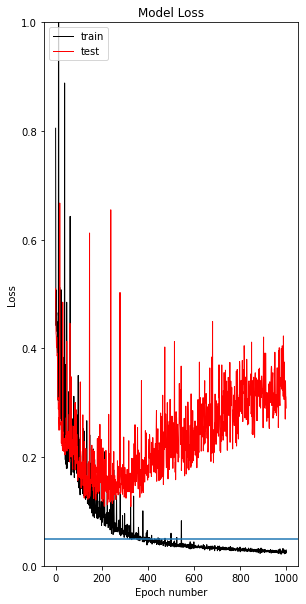

In [22]:
train_evaluate(train_data_sets=resisc_data_sets,
               test_data_sets=resisc_data_sets,
               unet_h5='/content/drive/My Drive/data_sets/resisc_only_unet.h5',
               num_epochs=1000,
               eval_repeat_count=100,
               min_water_pixel=100,
               show_predictions=False)

In [ ]:
train_evaluate(train_data_sets=resisc_data_sets,
               test_data_sets=resisc_data_sets,
               unet_h5='/content/drive/My Drive/data_sets/resisc_only_unet.h5',
               num_epochs=500,
               eval_repeat_count=100,
               min_water_pixel=60)

set water pixel prob:  0.234375
start training: epochs:  100 , steps: train:  9 , validation:  1 , test:  1
epoch[1] loss=0.6694778800010681, val_loss=0.4598630368709564, mean_iou=0.08%, val_mean_iou=0.90%
logs:  {'loss': 0.6694778800010681, 'mean_iou': 0.0007928612176328897, 'val_loss': 0.4598630368709564, 'val_mean_iou': 0.009009009227156639}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.3812499
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.37%


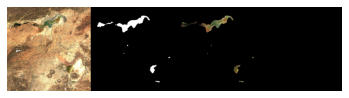

----------------
epoch[2] loss=0.3459189832210541, val_loss=0.34008944034576416, mean_iou=0.00%, val_mean_iou=0.12%
logs:  {'loss': 0.3459189832210541, 'mean_iou': 0.0, 'val_loss': 0.34008944034576416, 'val_mean_iou': 0.0011534024961292744}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.43656588
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 28.61%


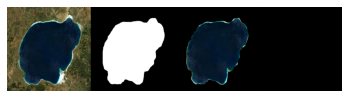

----------------
epoch[3] loss=0.31222060322761536, val_loss=0.31154540181159973, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.31222060322761536, 'mean_iou': 0.0, 'val_loss': 0.31154540181159973, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.4277238
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 44.34%


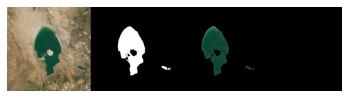

----------------
epoch[4] loss=0.2997242212295532, val_loss=0.32925114035606384, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.2997242212295532, 'mean_iou': 0.0, 'val_loss': 0.32925114035606384, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.3995168
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 44.34%


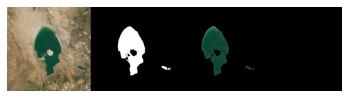

----------------
epoch[5] loss=0.2936994135379791, val_loss=0.2747390866279602, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.2936994135379791, 'mean_iou': 0.0, 'val_loss': 0.2747390866279602, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.3091554
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.78%


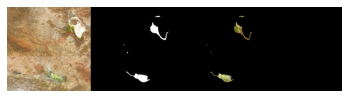

----------------
epoch[6] loss=0.4829954504966736, val_loss=0.3133479058742523, mean_iou=0.00%, val_mean_iou=2.80%
logs:  {'loss': 0.4829954504966736, 'mean_iou': 0.0, 'val_loss': 0.3133479058742523, 'val_mean_iou': 0.027960525825619698}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.45600304
[test_ds] mean-IoU: 82.64%
[test_ds] tf-mean-IoU: 90.32%


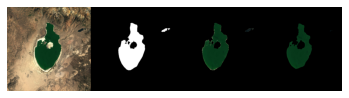

----------------
epoch[7] loss=0.27142223715782166, val_loss=0.2563999891281128, mean_iou=0.11%, val_mean_iou=0.55%
logs:  {'loss': 0.27142223715782166, 'mean_iou': 0.0010960404761135578, 'val_loss': 0.2563999891281128, 'val_mean_iou': 0.005464480724185705}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.4355967
[test_ds] mean-IoU: 72.02%
[test_ds] tf-mean-IoU: 84.42%


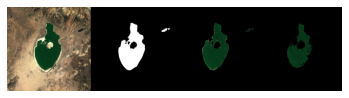

----------------
epoch[8] loss=0.2804463803768158, val_loss=0.2697300314903259, mean_iou=0.00%, val_mean_iou=9.89%
logs:  {'loss': 0.2804463803768158, 'mean_iou': 0.0, 'val_loss': 0.2697300314903259, 'val_mean_iou': 0.09885931760072708}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.50500345
[test_ds] mean-IoU: 91.68%
[test_ds] tf-mean-IoU: 94.97%


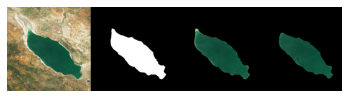

----------------
epoch[9] loss=0.2589486539363861, val_loss=0.28444772958755493, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.2589486539363861, 'mean_iou': 0.0, 'val_loss': 0.28444772958755493, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.4989579
[test_ds] mean-IoU: 34.38%
[test_ds] tf-mean-IoU: 63.33%


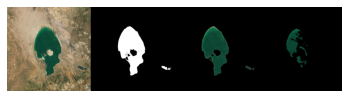

----------------
epoch[10] loss=0.24856097996234894, val_loss=0.23686355352401733, mean_iou=0.00%, val_mean_iou=1.05%
logs:  {'loss': 0.24856097996234894, 'mean_iou': 0.0, 'val_loss': 0.23686355352401733, 'val_mean_iou': 0.010526316240429878}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.43031973
[test_ds] mean-IoU: 0.03%
[test_ds] tf-mean-IoU: 46.41%


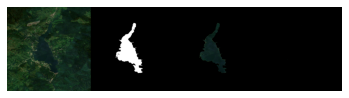

----------------
epoch[11] loss=0.24596203863620758, val_loss=0.23688916862010956, mean_iou=13.33%, val_mean_iou=0.00%
logs:  {'loss': 0.24596203863620758, 'mean_iou': 0.13333334028720856, 'val_loss': 0.23688916862010956, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.51666844
[test_ds] mean-IoU: 84.93%
[test_ds] tf-mean-IoU: 91.52%


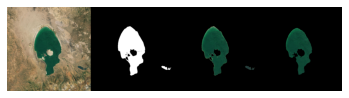

----------------
epoch[12] loss=0.23256534337997437, val_loss=0.22270244359970093, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.23256534337997437, 'mean_iou': 0.0, 'val_loss': 0.22270244359970093, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.5230589
[test_ds] mean-IoU: 84.91%
[test_ds] tf-mean-IoU: 91.51%


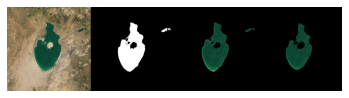

----------------
epoch[13] loss=0.2617640793323517, val_loss=0.1888601928949356, mean_iou=5.85%, val_mean_iou=0.00%
logs:  {'loss': 0.2617640793323517, 'mean_iou': 0.05847953259944916, 'val_loss': 0.1888601928949356, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.45907116
[test_ds] mean-IoU: 7.52%
[test_ds] tf-mean-IoU: 50.41%


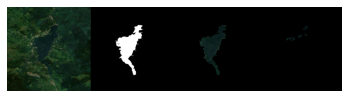

----------------
epoch[14] loss=0.28234168887138367, val_loss=0.24010488390922546, mean_iou=1.94%, val_mean_iou=0.00%
logs:  {'loss': 0.28234168887138367, 'mean_iou': 0.01944444328546524, 'val_loss': 0.24010488390922546, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.5327329
[test_ds] mean-IoU: 66.00%
[test_ds] tf-mean-IoU: 79.72%


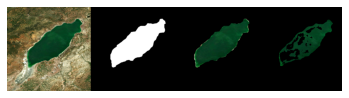

----------------
epoch[15] loss=0.22935417294502258, val_loss=0.17808225750923157, mean_iou=0.93%, val_mean_iou=0.00%
logs:  {'loss': 0.22935417294502258, 'mean_iou': 0.009318996220827103, 'val_loss': 0.17808225750923157, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.4329674
[test_ds] mean-IoU: 1.70%
[test_ds] tf-mean-IoU: 47.30%


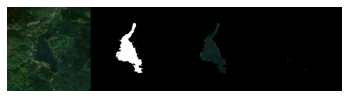

----------------
epoch[16] loss=0.235726460814476, val_loss=0.19852294027805328, mean_iou=15.70%, val_mean_iou=0.00%
logs:  {'loss': 0.235726460814476, 'mean_iou': 0.15695367753505707, 'val_loss': 0.19852294027805328, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.43605474
[test_ds] mean-IoU: 0.38%
[test_ds] tf-mean-IoU: 46.60%


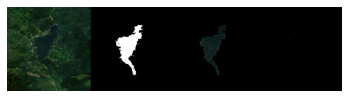

----------------
epoch[17] loss=0.2282782942056656, val_loss=0.17886430025100708, mean_iou=0.23%, val_mean_iou=0.00%
logs:  {'loss': 0.2282782942056656, 'mean_iou': 0.0023088022135198116, 'val_loss': 0.17886430025100708, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.34660777
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.37%


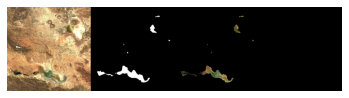

----------------
epoch[18] loss=0.21312613785266876, val_loss=0.1966341733932495, mean_iou=29.80%, val_mean_iou=0.00%
logs:  {'loss': 0.21312613785266876, 'mean_iou': 0.29804396629333496, 'val_loss': 0.1966341733932495, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.6699335
[test_ds] mean-IoU: 92.28%
[test_ds] tf-mean-IoU: 95.65%


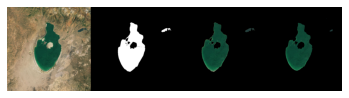

----------------
epoch[19] loss=0.22612203657627106, val_loss=0.17911675572395325, mean_iou=11.11%, val_mean_iou=0.00%
logs:  {'loss': 0.22612203657627106, 'mean_iou': 0.1111111119389534, 'val_loss': 0.17911675572395325, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.7699135
[test_ds] mean-IoU: 96.37%
[test_ds] tf-mean-IoU: 96.86%


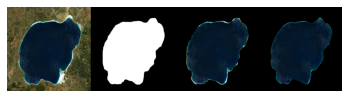

----------------
epoch[20] loss=0.2553976774215698, val_loss=0.1742365062236786, mean_iou=33.46%, val_mean_iou=0.00%
logs:  {'loss': 0.2553976774215698, 'mean_iou': 0.334574818611145, 'val_loss': 0.1742365062236786, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.7111173
[test_ds] mean-IoU: 90.55%
[test_ds] tf-mean-IoU: 94.73%


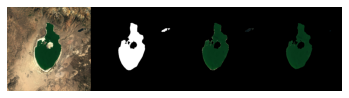

----------------
epoch[21] loss=0.18829114735126495, val_loss=0.19720838963985443, mean_iou=29.10%, val_mean_iou=0.00%
logs:  {'loss': 0.18829114735126495, 'mean_iou': 0.29100528359413147, 'val_loss': 0.19720838963985443, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.29220214
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.78%


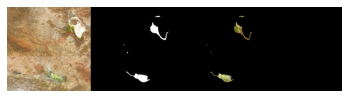

----------------
epoch[22] loss=0.15838244557380676, val_loss=0.13624072074890137, mean_iou=25.00%, val_mean_iou=0.00%
logs:  {'loss': 0.15838244557380676, 'mean_iou': 0.25, 'val_loss': 0.13624072074890137, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9895188
[test_ds] mean-IoU: 96.92%
[test_ds] tf-mean-IoU: 98.13%


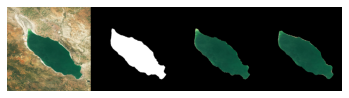

----------------
epoch[23] loss=0.281810998916626, val_loss=0.16857615113258362, mean_iou=35.84%, val_mean_iou=3.77%
logs:  {'loss': 0.281810998916626, 'mean_iou': 0.3583710491657257, 'val_loss': 0.16857615113258362, 'val_mean_iou': 0.03773584961891174}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9688308
[test_ds] mean-IoU: 94.36%
[test_ds] tf-mean-IoU: 96.84%


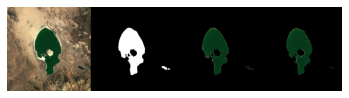

----------------
epoch[24] loss=0.5022422075271606, val_loss=0.16554777324199677, mean_iou=0.56%, val_mean_iou=9.27%
logs:  {'loss': 0.5022422075271606, 'mean_iou': 0.0055555556900799274, 'val_loss': 0.16554777324199677, 'val_mean_iou': 0.09271523356437683}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.89538485
[test_ds] mean-IoU: 97.18%
[test_ds] tf-mean-IoU: 97.55%


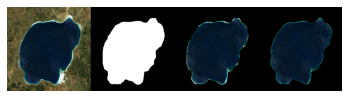

----------------
epoch[25] loss=0.19556592404842377, val_loss=0.15288816392421722, mean_iou=33.94%, val_mean_iou=0.00%
logs:  {'loss': 0.19556592404842377, 'mean_iou': 0.33937856554985046, 'val_loss': 0.15288816392421722, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.75593996
[test_ds] mean-IoU: 91.55%
[test_ds] tf-mean-IoU: 95.28%


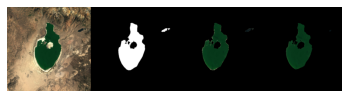

----------------
epoch[26] loss=0.15476442873477936, val_loss=0.15426218509674072, mean_iou=55.56%, val_mean_iou=0.00%
logs:  {'loss': 0.15476442873477936, 'mean_iou': 0.5555555820465088, 'val_loss': 0.15426218509674072, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.7055087
[test_ds] mean-IoU: 19.87%
[test_ds] tf-mean-IoU: 51.46%


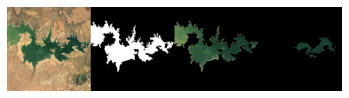

----------------
epoch[27] loss=0.1612696796655655, val_loss=0.14161425828933716, mean_iou=46.36%, val_mean_iou=0.00%
logs:  {'loss': 0.1612696796655655, 'mean_iou': 0.4636015295982361, 'val_loss': 0.14161425828933716, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.88224643
[test_ds] mean-IoU: 95.77%
[test_ds] tf-mean-IoU: 97.44%


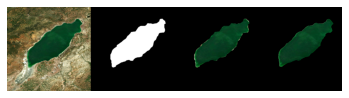

----------------
epoch[28] loss=0.15189608931541443, val_loss=0.17403995990753174, mean_iou=59.65%, val_mean_iou=0.00%
logs:  {'loss': 0.15189608931541443, 'mean_iou': 0.5964912176132202, 'val_loss': 0.17403995990753174, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.93065387
[test_ds] mean-IoU: 93.90%
[test_ds] tf-mean-IoU: 96.56%


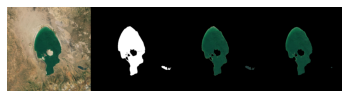

----------------
epoch[29] loss=0.15902087092399597, val_loss=0.1517353057861328, mean_iou=34.72%, val_mean_iou=0.00%
logs:  {'loss': 0.15902087092399597, 'mean_iou': 0.3472222089767456, 'val_loss': 0.1517353057861328, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.94653374
[test_ds] mean-IoU: 96.12%
[test_ds] tf-mean-IoU: 97.65%


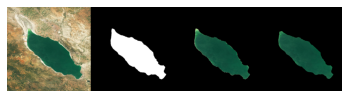

----------------
epoch[30] loss=0.13646423816680908, val_loss=0.1280943900346756, mean_iou=55.56%, val_mean_iou=0.00%
logs:  {'loss': 0.13646423816680908, 'mean_iou': 0.5555555820465088, 'val_loss': 0.1280943900346756, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99061465
[test_ds] mean-IoU: 97.61%
[test_ds] tf-mean-IoU: 97.92%


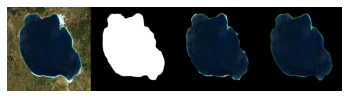

----------------
epoch[31] loss=0.25972115993499756, val_loss=0.16041399538516998, mean_iou=45.59%, val_mean_iou=0.00%
logs:  {'loss': 0.25972115993499756, 'mean_iou': 0.4558922350406647, 'val_loss': 0.16041399538516998, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9799135
[test_ds] mean-IoU: 97.35%
[test_ds] tf-mean-IoU: 97.70%


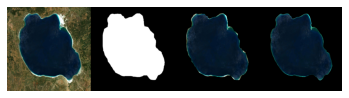

----------------
epoch[32] loss=0.13561518490314484, val_loss=0.13529953360557556, mean_iou=62.12%, val_mean_iou=0.00%
logs:  {'loss': 0.13561518490314484, 'mean_iou': 0.6212121248245239, 'val_loss': 0.13529953360557556, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.26483095
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.77%


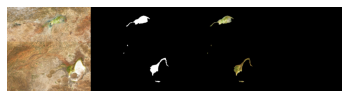

----------------
epoch[33] loss=0.12539909780025482, val_loss=0.27324607968330383, mean_iou=51.52%, val_mean_iou=0.00%
logs:  {'loss': 0.12539909780025482, 'mean_iou': 0.5151515007019043, 'val_loss': 0.27324607968330383, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.23282261
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.37%


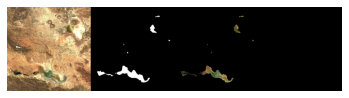

----------------
epoch[34] loss=0.18103185296058655, val_loss=0.19882023334503174, mean_iou=60.19%, val_mean_iou=0.00%
logs:  {'loss': 0.18103185296058655, 'mean_iou': 0.6018518805503845, 'val_loss': 0.19882023334503174, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9970794
[test_ds] mean-IoU: 83.51%
[test_ds] tf-mean-IoU: 90.51%


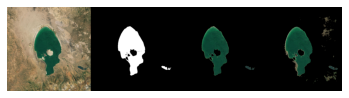

----------------
epoch[35] loss=0.12300051748752594, val_loss=0.1511642038822174, mean_iou=65.05%, val_mean_iou=0.00%
logs:  {'loss': 0.12300051748752594, 'mean_iou': 0.6504518985748291, 'val_loss': 0.1511642038822174, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9925
[test_ds] mean-IoU: 97.04%
[test_ds] tf-mean-IoU: 97.43%


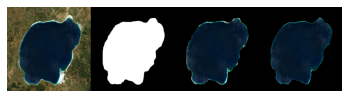

----------------
epoch[36] loss=0.14453110098838806, val_loss=0.10759183764457703, mean_iou=62.63%, val_mean_iou=0.00%
logs:  {'loss': 0.14453110098838806, 'mean_iou': 0.6262626051902771, 'val_loss': 0.10759183764457703, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.8777188
[test_ds] mean-IoU: 72.34%
[test_ds] tf-mean-IoU: 85.11%


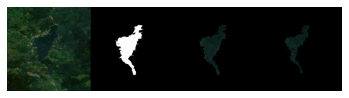

----------------
epoch[37] loss=0.15076549351215363, val_loss=0.15514081716537476, mean_iou=66.67%, val_mean_iou=0.00%
logs:  {'loss': 0.15076549351215363, 'mean_iou': 0.6666666865348816, 'val_loss': 0.15514081716537476, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.98534805
[test_ds] mean-IoU: 96.63%
[test_ds] tf-mean-IoU: 97.96%


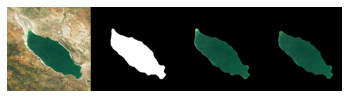

----------------
epoch[38] loss=0.1422894150018692, val_loss=0.13827334344387054, mean_iou=48.31%, val_mean_iou=0.00%
logs:  {'loss': 0.1422894150018692, 'mean_iou': 0.4830917716026306, 'val_loss': 0.13827334344387054, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.98859733
[test_ds] mean-IoU: 93.58%
[test_ds] tf-mean-IoU: 96.41%


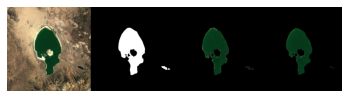

----------------
epoch[39] loss=0.17086809873580933, val_loss=0.12178681045770645, mean_iou=45.80%, val_mean_iou=0.00%
logs:  {'loss': 0.17086809873580933, 'mean_iou': 0.45799458026885986, 'val_loss': 0.12178681045770645, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.507845
[test_ds] mean-IoU: 0.13%
[test_ds] tf-mean-IoU: 48.44%


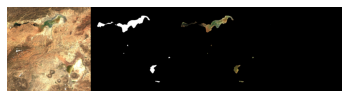

----------------
epoch[40] loss=0.1168534904718399, val_loss=0.12950760126113892, mean_iou=59.26%, val_mean_iou=26.72%
logs:  {'loss': 0.1168534904718399, 'mean_iou': 0.5925925970077515, 'val_loss': 0.12950760126113892, 'val_mean_iou': 0.2671755850315094}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9907386
[test_ds] mean-IoU: 75.82%
[test_ds] tf-mean-IoU: 84.94%


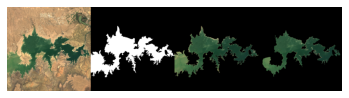

----------------
epoch[41] loss=1.564470887184143, val_loss=0.1378336250782013, mean_iou=66.67%, val_mean_iou=0.00%
logs:  {'loss': 1.564470887184143, 'mean_iou': 0.6666666865348816, 'val_loss': 0.1378336250782013, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.95987165
[test_ds] mean-IoU: 95.78%
[test_ds] tf-mean-IoU: 97.45%


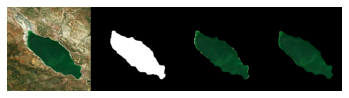

----------------
epoch[42] loss=0.1667691320180893, val_loss=0.13092243671417236, mean_iou=55.56%, val_mean_iou=0.00%
logs:  {'loss': 0.1667691320180893, 'mean_iou': 0.5555555820465088, 'val_loss': 0.13092243671417236, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.96712935
[test_ds] mean-IoU: 95.93%
[test_ds] tf-mean-IoU: 97.54%


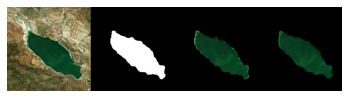

----------------
epoch[43] loss=0.15352754294872284, val_loss=0.12853817641735077, mean_iou=81.22%, val_mean_iou=0.00%
logs:  {'loss': 0.15352754294872284, 'mean_iou': 0.8121693134307861, 'val_loss': 0.12853817641735077, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9715494
[test_ds] mean-IoU: 93.79%
[test_ds] tf-mean-IoU: 96.50%


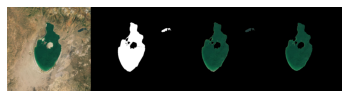

----------------
epoch[44] loss=0.1400216668844223, val_loss=0.22252985835075378, mean_iou=55.56%, val_mean_iou=0.00%
logs:  {'loss': 0.1400216668844223, 'mean_iou': 0.5555555820465088, 'val_loss': 0.22252985835075378, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.33798224
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.40%


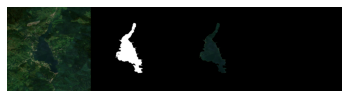

----------------
epoch[45] loss=0.12286683171987534, val_loss=0.11925099045038223, mean_iou=51.52%, val_mean_iou=0.00%
logs:  {'loss': 0.12286683171987534, 'mean_iou': 0.5151515007019043, 'val_loss': 0.11925099045038223, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9972727
[test_ds] mean-IoU: 97.88%
[test_ds] tf-mean-IoU: 98.72%


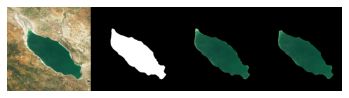

----------------
epoch[46] loss=0.15200267732143402, val_loss=0.32827529311180115, mean_iou=62.63%, val_mean_iou=0.00%
logs:  {'loss': 0.15200267732143402, 'mean_iou': 0.6262626051902771, 'val_loss': 0.32827529311180115, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.45795235
[test_ds] mean-IoU: 0.07%
[test_ds] tf-mean-IoU: 48.41%


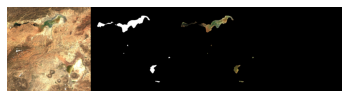

----------------
epoch[47] loss=0.147639200091362, val_loss=0.10762188583612442, mean_iou=66.67%, val_mean_iou=60.00%
logs:  {'loss': 0.147639200091362, 'mean_iou': 0.6666666865348816, 'val_loss': 0.10762188583612442, 'val_mean_iou': 0.6000000238418579}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9528398
[test_ds] mean-IoU: 60.49%
[test_ds] tf-mean-IoU: 75.64%


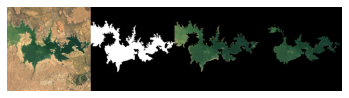

----------------
epoch[48] loss=0.11427557468414307, val_loss=0.10741094499826431, mean_iou=48.60%, val_mean_iou=0.00%
logs:  {'loss': 0.11427557468414307, 'mean_iou': 0.48604828119277954, 'val_loss': 0.10741094499826431, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9997123
[test_ds] mean-IoU: 95.54%
[test_ds] tf-mean-IoU: 97.30%


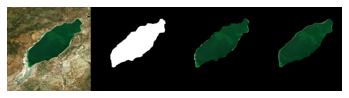

----------------
epoch[49] loss=0.09376705437898636, val_loss=0.11296482384204865, mean_iou=80.56%, val_mean_iou=0.00%
logs:  {'loss': 0.09376705437898636, 'mean_iou': 0.8055555820465088, 'val_loss': 0.11296482384204865, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.8894898
[test_ds] mean-IoU: 45.28%
[test_ds] tf-mean-IoU: 70.59%


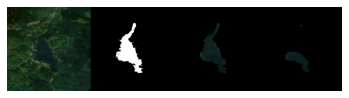

----------------
epoch[50] loss=0.16721941530704498, val_loss=0.09926967322826385, mean_iou=27.78%, val_mean_iou=0.00%
logs:  {'loss': 0.16721941530704498, 'mean_iou': 0.2777777910232544, 'val_loss': 0.09926967322826385, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9927683
[test_ds] mean-IoU: 97.92%
[test_ds] tf-mean-IoU: 98.74%


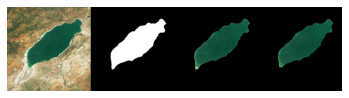

----------------
epoch[51] loss=0.10366496443748474, val_loss=0.11382412165403366, mean_iou=79.08%, val_mean_iou=0.00%
logs:  {'loss': 0.10366496443748474, 'mean_iou': 0.7908496856689453, 'val_loss': 0.11382412165403366, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99971074
[test_ds] mean-IoU: 97.78%
[test_ds] tf-mean-IoU: 98.06%


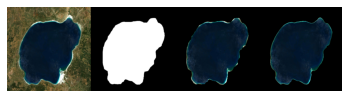

----------------
epoch[52] loss=0.12907712161540985, val_loss=0.14863470196723938, mean_iou=59.84%, val_mean_iou=0.00%
logs:  {'loss': 0.12907712161540985, 'mean_iou': 0.5984078645706177, 'val_loss': 0.14863470196723938, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.98359674
[test_ds] mean-IoU: 95.95%
[test_ds] tf-mean-IoU: 97.55%


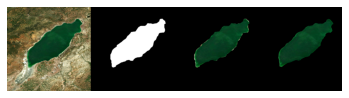

----------------
epoch[53] loss=0.152720645070076, val_loss=0.1855599582195282, mean_iou=51.01%, val_mean_iou=0.00%
logs:  {'loss': 0.152720645070076, 'mean_iou': 0.5101010203361511, 'val_loss': 0.1855599582195282, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9985752
[test_ds] mean-IoU: 96.48%
[test_ds] tf-mean-IoU: 96.95%


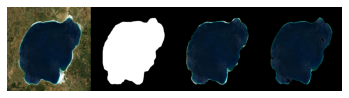

----------------
epoch[54] loss=0.12613636255264282, val_loss=0.15981540083885193, mean_iou=63.04%, val_mean_iou=0.00%
logs:  {'loss': 0.12613636255264282, 'mean_iou': 0.6304347515106201, 'val_loss': 0.15981540083885193, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9858559
[test_ds] mean-IoU: 96.12%
[test_ds] tf-mean-IoU: 97.65%


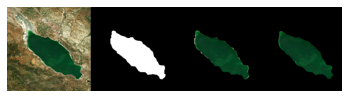

----------------
epoch[55] loss=0.09973833709955215, val_loss=0.09078612178564072, mean_iou=55.56%, val_mean_iou=0.00%
logs:  {'loss': 0.09973833709955215, 'mean_iou': 0.5555555820465088, 'val_loss': 0.09078612178564072, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9996761
[test_ds] mean-IoU: 94.93%
[test_ds] tf-mean-IoU: 97.13%


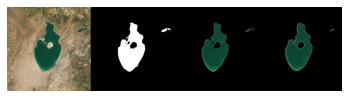

----------------
epoch[56] loss=0.08031013607978821, val_loss=0.1542946845293045, mean_iou=72.37%, val_mean_iou=0.00%
logs:  {'loss': 0.08031013607978821, 'mean_iou': 0.7237237095832825, 'val_loss': 0.1542946845293045, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9990048
[test_ds] mean-IoU: 96.62%
[test_ds] tf-mean-IoU: 97.96%


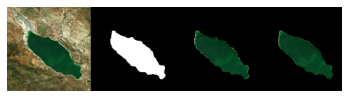

----------------
epoch[57] loss=0.11206220090389252, val_loss=0.27138006687164307, mean_iou=75.55%, val_mean_iou=60.71%
logs:  {'loss': 0.11206220090389252, 'mean_iou': 0.7554713487625122, 'val_loss': 0.27138006687164307, 'val_mean_iou': 0.6071428656578064}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  1.0
[test_ds] mean-IoU: 57.72%
[test_ds] tf-mean-IoU: 74.56%


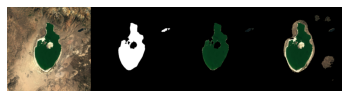

----------------
epoch[58] loss=0.15153498947620392, val_loss=0.11743271350860596, mean_iou=55.56%, val_mean_iou=83.33%
logs:  {'loss': 0.15153498947620392, 'mean_iou': 0.5555555820465088, 'val_loss': 0.11743271350860596, 'val_mean_iou': 0.8333333134651184}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.989441
[test_ds] mean-IoU: 62.67%
[test_ds] tf-mean-IoU: 79.23%


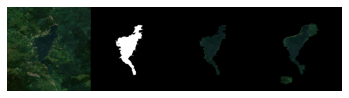

----------------
epoch[59] loss=0.08023921400308609, val_loss=0.0993213802576065, mean_iou=80.25%, val_mean_iou=0.00%
logs:  {'loss': 0.08023921400308609, 'mean_iou': 0.8024691343307495, 'val_loss': 0.0993213802576065, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999769
[test_ds] mean-IoU: 97.75%
[test_ds] tf-mean-IoU: 98.04%


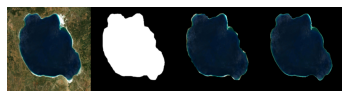

----------------
epoch[60] loss=0.19026274979114532, val_loss=0.15170159935951233, mean_iou=44.44%, val_mean_iou=0.00%
logs:  {'loss': 0.19026274979114532, 'mean_iou': 0.4444444477558136, 'val_loss': 0.15170159935951233, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.26733354
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.77%


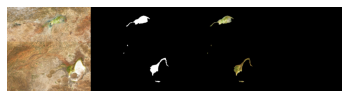

----------------
epoch[61] loss=0.10560095310211182, val_loss=0.09387516230344772, mean_iou=57.33%, val_mean_iou=0.00%
logs:  {'loss': 0.10560095310211182, 'mean_iou': 0.5733333230018616, 'val_loss': 0.09387516230344772, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9998995
[test_ds] mean-IoU: 95.91%
[test_ds] tf-mean-IoU: 97.52%


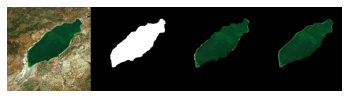

----------------
epoch[62] loss=0.12731413543224335, val_loss=0.10302310436964035, mean_iou=63.70%, val_mean_iou=18.42%
logs:  {'loss': 0.12731413543224335, 'mean_iou': 0.6370370388031006, 'val_loss': 0.10302310436964035, 'val_mean_iou': 0.18421052396297455}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999988
[test_ds] mean-IoU: 94.43%
[test_ds] tf-mean-IoU: 96.61%


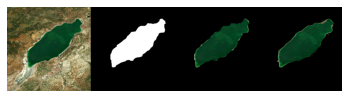

----------------
epoch[63] loss=0.08287021517753601, val_loss=0.1364489644765854, mean_iou=67.49%, val_mean_iou=0.00%
logs:  {'loss': 0.08287021517753601, 'mean_iou': 0.6748737096786499, 'val_loss': 0.1364489644765854, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9050438
[test_ds] mean-IoU: 35.33%
[test_ds] tf-mean-IoU: 65.27%


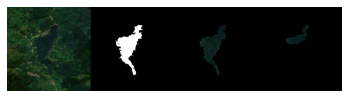

----------------
epoch[64] loss=0.07312963157892227, val_loss=0.09733329713344574, mean_iou=67.35%, val_mean_iou=0.00%
logs:  {'loss': 0.07312963157892227, 'mean_iou': 0.6734549403190613, 'val_loss': 0.09733329713344574, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  1.0
[test_ds] mean-IoU: 83.29%
[test_ds] tf-mean-IoU: 90.47%


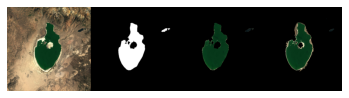

----------------
epoch[65] loss=0.1208905279636383, val_loss=0.08387600630521774, mean_iou=68.07%, val_mean_iou=0.00%
logs:  {'loss': 0.1208905279636383, 'mean_iou': 0.6807070374488831, 'val_loss': 0.08387600630521774, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999908
[test_ds] mean-IoU: 97.82%
[test_ds] tf-mean-IoU: 98.10%


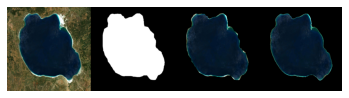

----------------
epoch[66] loss=0.08521241694688797, val_loss=0.1650092750787735, mean_iou=49.83%, val_mean_iou=0.00%
logs:  {'loss': 0.08521241694688797, 'mean_iou': 0.4983164966106415, 'val_loss': 0.1650092750787735, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.992044
[test_ds] mean-IoU: 59.42%
[test_ds] tf-mean-IoU: 77.12%


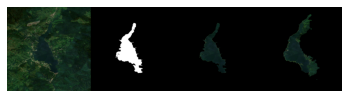

----------------
epoch[67] loss=0.11117919534444809, val_loss=0.39509329199790955, mean_iou=73.23%, val_mean_iou=0.00%
logs:  {'loss': 0.11117919534444809, 'mean_iou': 0.7323232293128967, 'val_loss': 0.39509329199790955, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9942935
[test_ds] mean-IoU: 93.65%
[test_ds] tf-mean-IoU: 96.42%


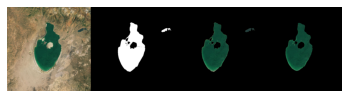

----------------
epoch[68] loss=0.11535157263278961, val_loss=0.08944859355688095, mean_iou=71.77%, val_mean_iou=0.00%
logs:  {'loss': 0.11535157263278961, 'mean_iou': 0.7177425026893616, 'val_loss': 0.08944859355688095, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  1.0
[test_ds] mean-IoU: 81.37%
[test_ds] tf-mean-IoU: 89.35%


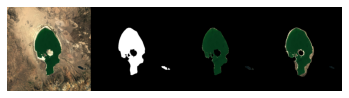

----------------
epoch[69] loss=0.07385488599538803, val_loss=0.14516589045524597, mean_iou=64.40%, val_mean_iou=0.00%
logs:  {'loss': 0.07385488599538803, 'mean_iou': 0.644032895565033, 'val_loss': 0.14516589045524597, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999156
[test_ds] mean-IoU: 93.75%
[test_ds] tf-mean-IoU: 96.50%


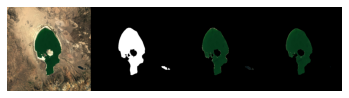

----------------
epoch[70] loss=0.06641963124275208, val_loss=0.12780514359474182, mean_iou=94.95%, val_mean_iou=2.50%
logs:  {'loss': 0.06641963124275208, 'mean_iou': 0.9494948983192444, 'val_loss': 0.12780514359474182, 'val_mean_iou': 0.02500000037252903}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99999917
[test_ds] mean-IoU: 90.01%
[test_ds] tf-mean-IoU: 94.30%


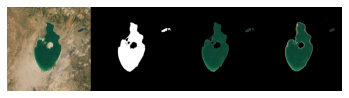

----------------
epoch[71] loss=0.09663734585046768, val_loss=0.1607782244682312, mean_iou=77.78%, val_mean_iou=0.00%
logs:  {'loss': 0.09663734585046768, 'mean_iou': 0.7777777910232544, 'val_loss': 0.1607782244682312, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  1.0
[test_ds] mean-IoU: 97.16%
[test_ds] tf-mean-IoU: 97.51%


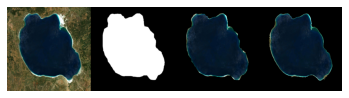

----------------
epoch[72] loss=0.09215976297855377, val_loss=0.092752605676651, mean_iou=46.91%, val_mean_iou=0.00%
logs:  {'loss': 0.09215976297855377, 'mean_iou': 0.4691358208656311, 'val_loss': 0.092752605676651, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9997398
[test_ds] mean-IoU: 96.58%
[test_ds] tf-mean-IoU: 97.93%


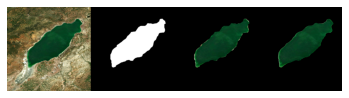

----------------
epoch[73] loss=0.06441165506839752, val_loss=0.13292689621448517, mean_iou=91.85%, val_mean_iou=0.00%
logs:  {'loss': 0.06441165506839752, 'mean_iou': 0.9185184836387634, 'val_loss': 0.13292689621448517, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  1.0
[test_ds] mean-IoU: 87.16%
[test_ds] tf-mean-IoU: 92.73%


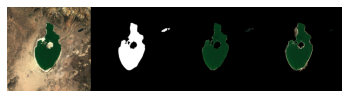

----------------
epoch[74] loss=0.07821718603372574, val_loss=0.09647198021411896, mean_iou=62.85%, val_mean_iou=2.63%
logs:  {'loss': 0.07821718603372574, 'mean_iou': 0.6285349726676941, 'val_loss': 0.09647198021411896, 'val_mean_iou': 0.02631578966975212}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999982
[test_ds] mean-IoU: 93.25%
[test_ds] tf-mean-IoU: 96.17%


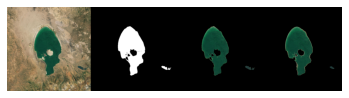

----------------
epoch[75] loss=0.06059688329696655, val_loss=0.10626475512981415, mean_iou=75.25%, val_mean_iou=0.00%
logs:  {'loss': 0.06059688329696655, 'mean_iou': 0.752525269985199, 'val_loss': 0.10626475512981415, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.87798494
[test_ds] mean-IoU: 59.23%
[test_ds] tf-mean-IoU: 78.08%


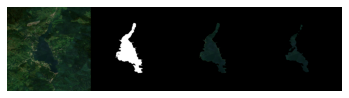

----------------
epoch[76] loss=0.117978535592556, val_loss=0.1489810347557068, mean_iou=61.38%, val_mean_iou=0.00%
logs:  {'loss': 0.117978535592556, 'mean_iou': 0.6137565970420837, 'val_loss': 0.1489810347557068, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.998629
[test_ds] mean-IoU: 97.62%
[test_ds] tf-mean-IoU: 98.56%


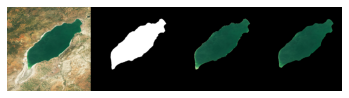

----------------
epoch[77] loss=0.1036982387304306, val_loss=0.09636653959751129, mean_iou=68.83%, val_mean_iou=0.00%
logs:  {'loss': 0.1036982387304306, 'mean_iou': 0.6882716417312622, 'val_loss': 0.09636653959751129, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9927844
[test_ds] mean-IoU: 67.81%
[test_ds] tf-mean-IoU: 80.07%


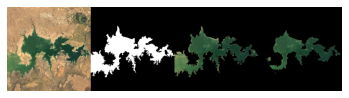

----------------
epoch[78] loss=0.05511273443698883, val_loss=0.09232178330421448, mean_iou=88.89%, val_mean_iou=0.00%
logs:  {'loss': 0.05511273443698883, 'mean_iou': 0.8888888955116272, 'val_loss': 0.09232178330421448, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.8638099
[test_ds] mean-IoU: 20.53%
[test_ds] tf-mean-IoU: 59.11%


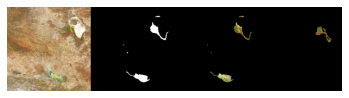

----------------
epoch[79] loss=0.10612449049949646, val_loss=0.08447594195604324, mean_iou=69.05%, val_mean_iou=0.00%
logs:  {'loss': 0.10612449049949646, 'mean_iou': 0.6904761791229248, 'val_loss': 0.08447594195604324, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99888164
[test_ds] mean-IoU: 96.48%
[test_ds] tf-mean-IoU: 98.02%


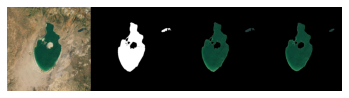

----------------
epoch[80] loss=0.07732462137937546, val_loss=0.08986257016658783, mean_iou=77.78%, val_mean_iou=0.00%
logs:  {'loss': 0.07732462137937546, 'mean_iou': 0.7777777910232544, 'val_loss': 0.08986257016658783, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999995
[test_ds] mean-IoU: 96.39%
[test_ds] tf-mean-IoU: 97.81%


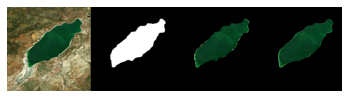

----------------
epoch[81] loss=0.05584237352013588, val_loss=0.06790120154619217, mean_iou=100.00%, val_mean_iou=2.86%
logs:  {'loss': 0.05584237352013588, 'mean_iou': 1.0, 'val_loss': 0.06790120154619217, 'val_mean_iou': 0.02857142873108387}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.41845435
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.77%


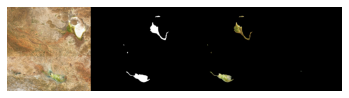

----------------
epoch[82] loss=0.0669015645980835, val_loss=0.20862028002738953, mean_iou=77.15%, val_mean_iou=0.00%
logs:  {'loss': 0.0669015645980835, 'mean_iou': 0.7714946866035461, 'val_loss': 0.20862028002738953, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9987832
[test_ds] mean-IoU: 93.04%
[test_ds] tf-mean-IoU: 96.08%


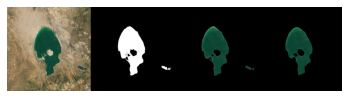

----------------
epoch[83] loss=0.08513694256544113, val_loss=0.10045427083969116, mean_iou=67.34%, val_mean_iou=0.00%
logs:  {'loss': 0.08513694256544113, 'mean_iou': 0.6734006404876709, 'val_loss': 0.10045427083969116, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99996936
[test_ds] mean-IoU: 83.79%
[test_ds] tf-mean-IoU: 89.82%


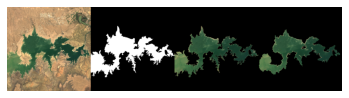

----------------
epoch[84] loss=0.06213908642530441, val_loss=0.15437611937522888, mean_iou=80.30%, val_mean_iou=0.00%
logs:  {'loss': 0.06213908642530441, 'mean_iou': 0.8030303120613098, 'val_loss': 0.15437611937522888, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99998474
[test_ds] mean-IoU: 70.21%
[test_ds] tf-mean-IoU: 81.32%


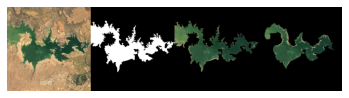

----------------
epoch[85] loss=0.06640578806400299, val_loss=0.09436057507991791, mean_iou=61.38%, val_mean_iou=0.00%
logs:  {'loss': 0.06640578806400299, 'mean_iou': 0.6137565970420837, 'val_loss': 0.09436057507991791, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  1.0
[test_ds] mean-IoU: 96.73%
[test_ds] tf-mean-IoU: 98.02%


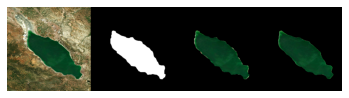

----------------
epoch[86] loss=0.06836411356925964, val_loss=0.13227304816246033, mean_iou=77.78%, val_mean_iou=0.00%
logs:  {'loss': 0.06836411356925964, 'mean_iou': 0.7777777910232544, 'val_loss': 0.13227304816246033, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9998983
[test_ds] mean-IoU: 97.70%
[test_ds] tf-mean-IoU: 98.00%


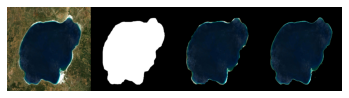

----------------
epoch[87] loss=0.07558342069387436, val_loss=0.0862719863653183, mean_iou=88.89%, val_mean_iou=0.00%
logs:  {'loss': 0.07558342069387436, 'mean_iou': 0.8888888955116272, 'val_loss': 0.0862719863653183, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999646
[test_ds] mean-IoU: 95.74%
[test_ds] tf-mean-IoU: 97.60%


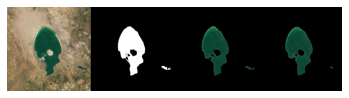

----------------
epoch[88] loss=0.04449833929538727, val_loss=0.10059013962745667, mean_iou=39.15%, val_mean_iou=0.00%
logs:  {'loss': 0.04449833929538727, 'mean_iou': 0.39153438806533813, 'val_loss': 0.10059013962745667, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.91942316
[test_ds] mean-IoU: 22.02%
[test_ds] tf-mean-IoU: 59.82%


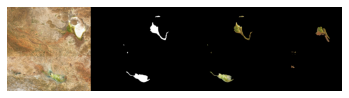

----------------
epoch[89] loss=0.2243664264678955, val_loss=0.10239168256521225, mean_iou=83.95%, val_mean_iou=0.00%
logs:  {'loss': 0.2243664264678955, 'mean_iou': 0.8395061492919922, 'val_loss': 0.10239168256521225, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9998971
[test_ds] mean-IoU: 96.59%
[test_ds] tf-mean-IoU: 97.94%


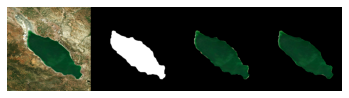

----------------
epoch[90] loss=0.05151936411857605, val_loss=0.09860243648290634, mean_iou=88.89%, val_mean_iou=0.00%
logs:  {'loss': 0.05151936411857605, 'mean_iou': 0.8888888955116272, 'val_loss': 0.09860243648290634, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999982
[test_ds] mean-IoU: 94.90%
[test_ds] tf-mean-IoU: 97.12%


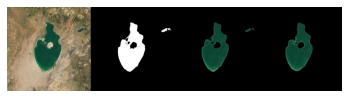

----------------
epoch[91] loss=0.047927722334861755, val_loss=0.14877915382385254, mean_iou=88.89%, val_mean_iou=0.00%
logs:  {'loss': 0.047927722334861755, 'mean_iou': 0.8888888955116272, 'val_loss': 0.14877915382385254, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.78982466
[test_ds] mean-IoU: 7.12%
[test_ds] tf-mean-IoU: 50.20%


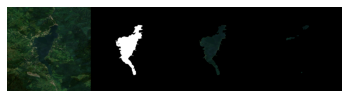

----------------
epoch[92] loss=0.05639031156897545, val_loss=0.10993051528930664, mean_iou=56.79%, val_mean_iou=0.00%
logs:  {'loss': 0.05639031156897545, 'mean_iou': 0.5679012537002563, 'val_loss': 0.10993051528930664, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999168
[test_ds] mean-IoU: 97.90%
[test_ds] tf-mean-IoU: 98.73%


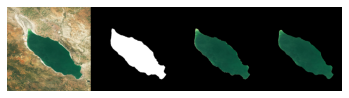

----------------
epoch[93] loss=0.06104113534092903, val_loss=0.07962198555469513, mean_iou=52.00%, val_mean_iou=0.00%
logs:  {'loss': 0.06104113534092903, 'mean_iou': 0.5200085043907166, 'val_loss': 0.07962198555469513, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99986446
[test_ds] mean-IoU: 82.25%
[test_ds] tf-mean-IoU: 88.92%


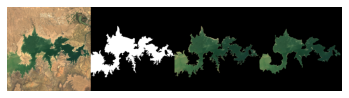

----------------
epoch[94] loss=0.044059980660676956, val_loss=0.09055861085653305, mean_iou=81.20%, val_mean_iou=0.00%
logs:  {'loss': 0.044059980660676956, 'mean_iou': 0.811965823173523, 'val_loss': 0.09055861085653305, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  1.0
[test_ds] mean-IoU: 98.57%
[test_ds] tf-mean-IoU: 99.13%


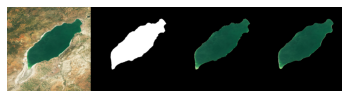

----------------
epoch[95] loss=0.06605733931064606, val_loss=0.17610161006450653, mean_iou=76.69%, val_mean_iou=0.00%
logs:  {'loss': 0.06605733931064606, 'mean_iou': 0.7668845653533936, 'val_loss': 0.17610161006450653, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.93668115
[test_ds] mean-IoU: 75.14%
[test_ds] tf-mean-IoU: 86.50%


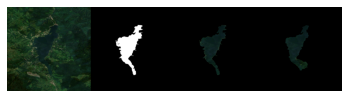

----------------
epoch[96] loss=0.04928499832749367, val_loss=0.3093027174472809, mean_iou=74.07%, val_mean_iou=0.00%
logs:  {'loss': 0.04928499832749367, 'mean_iou': 0.7407407164573669, 'val_loss': 0.3093027174472809, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  1.0
[test_ds] mean-IoU: 79.53%
[test_ds] tf-mean-IoU: 86.65%


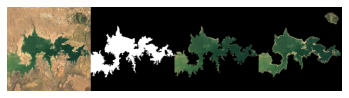

----------------
epoch[97] loss=0.10569296032190323, val_loss=0.08751705288887024, mean_iou=68.38%, val_mean_iou=0.00%
logs:  {'loss': 0.10569296032190323, 'mean_iou': 0.6837607026100159, 'val_loss': 0.08751705288887024, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9273639
[test_ds] mean-IoU: 36.10%
[test_ds] tf-mean-IoU: 66.98%


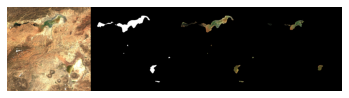

----------------
epoch[98] loss=0.042610034346580505, val_loss=0.0835818499326706, mean_iou=73.33%, val_mean_iou=0.00%
logs:  {'loss': 0.042610034346580505, 'mean_iou': 0.7333333492279053, 'val_loss': 0.0835818499326706, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99999344
[test_ds] mean-IoU: 97.60%
[test_ds] tf-mean-IoU: 97.91%


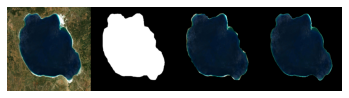

----------------
epoch[99] loss=0.041197534650564194, val_loss=0.11698932945728302, mean_iou=88.89%, val_mean_iou=0.00%
logs:  {'loss': 0.041197534650564194, 'mean_iou': 0.8888888955116272, 'val_loss': 0.11698932945728302, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.2791123
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.78%


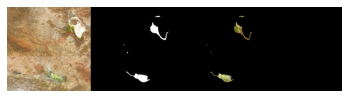

----------------
epoch[100] loss=0.04320359230041504, val_loss=0.0964476615190506, mean_iou=66.67%, val_mean_iou=0.00%
logs:  {'loss': 0.04320359230041504, 'mean_iou': 0.6666666865348816, 'val_loss': 0.0964476615190506, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.974116
[test_ds] mean-IoU: 62.09%
[test_ds] tf-mean-IoU: 76.62%


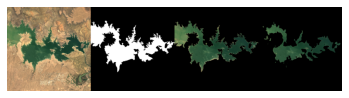

----------------
evaluate: test data set repeat count:  20
40/40 [==============================] - 19s 463ms/step - loss: 0.0642 - mean_iou: 0.5000
test loss, test acc: [0.0641527995467186, 0.5]


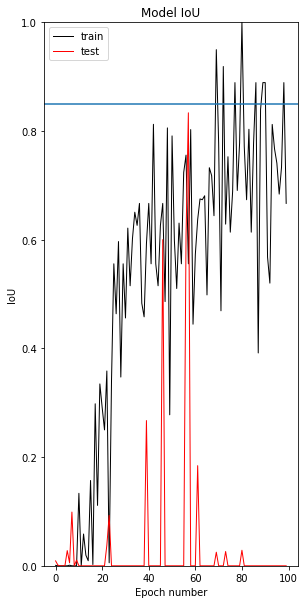

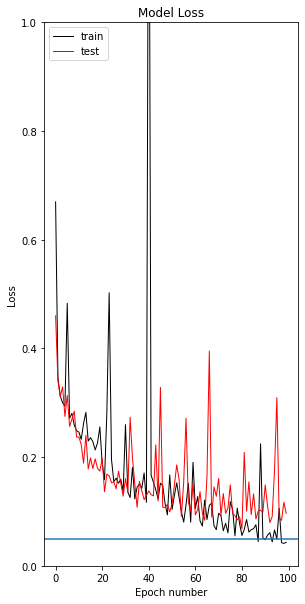

In [ ]:
train_evaluate(train_data_sets=s2_data_sets,
               test_data_sets=s2_data_sets,
               unet_h5='/content/drive/My Drive/data_sets/s2_only_unet.h5',
               image_shape=(512, 512, 3),
               num_epochs=100,
               eval_repeat_count=20,
               min_water_pixel=60)

set water pixel prob:  0.390625
start training: epochs:  100 , steps: train:  9 , validation:  1 , test:  1
epoch[1] loss=0.6459030508995056, val_loss=0.2821192741394043, mean_iou=0.02%, val_mean_iou=0.00%
logs:  {'loss': 0.6459030508995056, 'mean_iou': 0.00021701389050576836, 'val_loss': 0.2821192741394043, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.46619344
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.25%


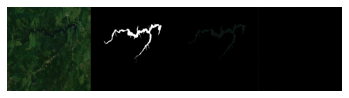

----------------
epoch[2] loss=0.33927690982818604, val_loss=0.3099510371685028, mean_iou=0.01%, val_mean_iou=0.00%
logs:  {'loss': 0.33927690982818604, 'mean_iou': 5.547234832192771e-05, 'val_loss': 0.3099510371685028, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.41539
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 43.98%


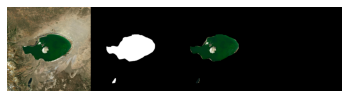

----------------
epoch[3] loss=0.31929337978363037, val_loss=0.2969237267971039, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.31929337978363037, 'mean_iou': 0.0, 'val_loss': 0.2969237267971039, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.37850267
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 41.25%


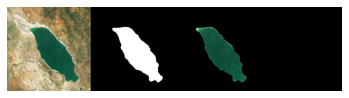

----------------
epoch[4] loss=0.3019629418849945, val_loss=0.2790340781211853, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.3019629418849945, 'mean_iou': 0.0, 'val_loss': 0.2790340781211853, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.41787058
[test_ds] mean-IoU: 0.19%
[test_ds] tf-mean-IoU: 44.09%


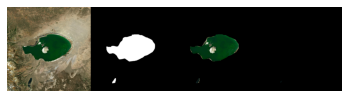

----------------
epoch[5] loss=0.29502615332603455, val_loss=0.277601957321167, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.29502615332603455, 'mean_iou': 0.0, 'val_loss': 0.277601957321167, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.4365594
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.44%


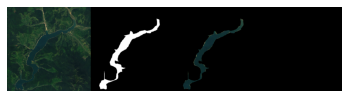

----------------
epoch[6] loss=0.28259748220443726, val_loss=0.26663529872894287, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.28259748220443726, 'mean_iou': 0.0, 'val_loss': 0.26663529872894287, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.28518498
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.31%


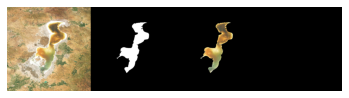

----------------
epoch[7] loss=0.2691054344177246, val_loss=0.2993086278438568, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.2691054344177246, 'mean_iou': 0.0, 'val_loss': 0.2993086278438568, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.50076586
[test_ds] mean-IoU: 44.60%
[test_ds] tf-mean-IoU: 66.90%


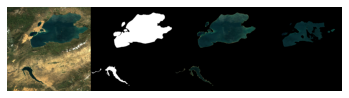

----------------
epoch[8] loss=0.27078163623809814, val_loss=0.22842201590538025, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.27078163623809814, 'mean_iou': 0.0, 'val_loss': 0.22842201590538025, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.5174848
[test_ds] mean-IoU: 72.07%
[test_ds] tf-mean-IoU: 84.94%


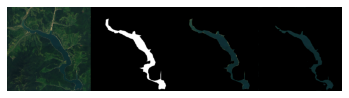

----------------
epoch[9] loss=0.2726934254169464, val_loss=0.25328323245048523, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.2726934254169464, 'mean_iou': 0.0, 'val_loss': 0.25328323245048523, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.37733462
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 43.98%


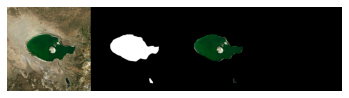

----------------
epoch[10] loss=0.24947892129421234, val_loss=0.22814533114433289, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.24947892129421234, 'mean_iou': 0.0, 'val_loss': 0.22814533114433289, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.26107776
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.31%


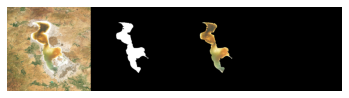

----------------
epoch[11] loss=0.2564755976200104, val_loss=0.2241726517677307, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.2564755976200104, 'mean_iou': 0.0, 'val_loss': 0.2241726517677307, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.58372724
[test_ds] mean-IoU: 1.37%
[test_ds] tf-mean-IoU: 44.74%


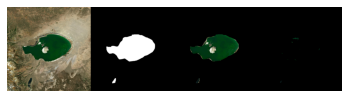

----------------
epoch[12] loss=0.2577928602695465, val_loss=0.21841885149478912, mean_iou=11.11%, val_mean_iou=0.00%
logs:  {'loss': 0.2577928602695465, 'mean_iou': 0.1111111119389534, 'val_loss': 0.21841885149478912, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.6730909
[test_ds] mean-IoU: 91.76%
[test_ds] tf-mean-IoU: 95.02%


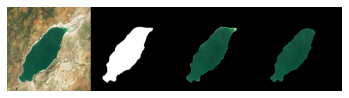

----------------
epoch[13] loss=0.25632503628730774, val_loss=0.2212328314781189, mean_iou=0.00%, val_mean_iou=0.00%
logs:  {'loss': 0.25632503628730774, 'mean_iou': 0.0, 'val_loss': 0.2212328314781189, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.7450556
[test_ds] mean-IoU: 31.11%
[test_ds] tf-mean-IoU: 59.28%


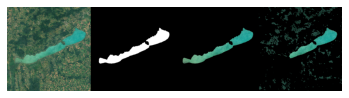

----------------
epoch[14] loss=0.24384957551956177, val_loss=0.17401456832885742, mean_iou=11.11%, val_mean_iou=100.00%
logs:  {'loss': 0.24384957551956177, 'mean_iou': 0.1111111119389534, 'val_loss': 0.17401456832885742, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.58303404
[test_ds] mean-IoU: 67.54%
[test_ds] tf-mean-IoU: 82.80%


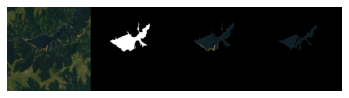

----------------
epoch[15] loss=0.23408934473991394, val_loss=0.17764747142791748, mean_iou=22.29%, val_mean_iou=0.00%
logs:  {'loss': 0.23408934473991394, 'mean_iou': 0.22292545437812805, 'val_loss': 0.17764747142791748, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.63353264
[test_ds] mean-IoU: 61.49%
[test_ds] tf-mean-IoU: 79.30%


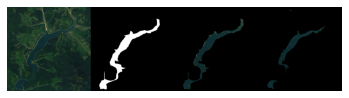

----------------
epoch[16] loss=0.252978652715683, val_loss=0.20614364743232727, mean_iou=11.11%, val_mean_iou=0.00%
logs:  {'loss': 0.252978652715683, 'mean_iou': 0.1111111119389534, 'val_loss': 0.20614364743232727, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.49917915
[test_ds] mean-IoU: 7.09%
[test_ds] tf-mean-IoU: 52.13%


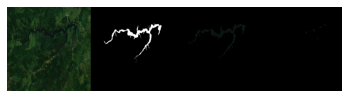

----------------
epoch[17] loss=0.20464353263378143, val_loss=0.16981934010982513, mean_iou=22.22%, val_mean_iou=0.00%
logs:  {'loss': 0.20464353263378143, 'mean_iou': 0.2222222238779068, 'val_loss': 0.16981934010982513, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.3983513
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.48%


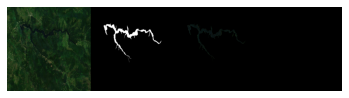

----------------
epoch[18] loss=0.21061015129089355, val_loss=0.19448816776275635, mean_iou=0.21%, val_mean_iou=0.00%
logs:  {'loss': 0.21061015129089355, 'mean_iou': 0.002116402145475149, 'val_loss': 0.19448816776275635, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.4073432
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.48%


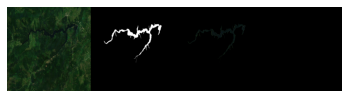

----------------
epoch[19] loss=0.21394820511341095, val_loss=0.21341460943222046, mean_iou=0.11%, val_mean_iou=0.00%
logs:  {'loss': 0.21394820511341095, 'mean_iou': 0.0010946907568722963, 'val_loss': 0.21341460943222046, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.7467929
[test_ds] mean-IoU: 53.68%
[test_ds] tf-mean-IoU: 72.46%


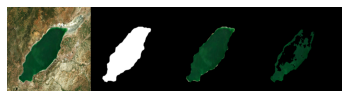

----------------
epoch[20] loss=0.19613370299339294, val_loss=0.11779894679784775, mean_iou=7.41%, val_mean_iou=0.00%
logs:  {'loss': 0.19613370299339294, 'mean_iou': 0.07407407462596893, 'val_loss': 0.11779894679784775, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.89658004
[test_ds] mean-IoU: 86.86%
[test_ds] tf-mean-IoU: 92.54%


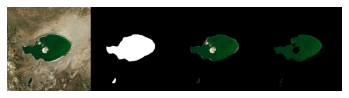

----------------
epoch[21] loss=0.6775969862937927, val_loss=0.20463824272155762, mean_iou=14.74%, val_mean_iou=0.00%
logs:  {'loss': 0.6775969862937927, 'mean_iou': 0.14743590354919434, 'val_loss': 0.20463824272155762, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.83778995
[test_ds] mean-IoU: 70.42%
[test_ds] tf-mean-IoU: 82.32%


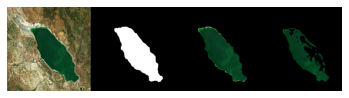

----------------
epoch[22] loss=0.2004394680261612, val_loss=0.17761382460594177, mean_iou=25.40%, val_mean_iou=0.00%
logs:  {'loss': 0.2004394680261612, 'mean_iou': 0.2539682388305664, 'val_loss': 0.17761382460594177, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.36730143
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.31%


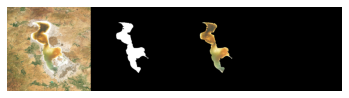

----------------
epoch[23] loss=0.20817464590072632, val_loss=0.17975769937038422, mean_iou=34.63%, val_mean_iou=0.00%
logs:  {'loss': 0.20817464590072632, 'mean_iou': 0.34634634852409363, 'val_loss': 0.17975769937038422, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.7896978
[test_ds] mean-IoU: 57.30%
[test_ds] tf-mean-IoU: 76.21%


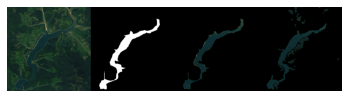

----------------
epoch[24] loss=0.17062416672706604, val_loss=0.12124954164028168, mean_iou=27.47%, val_mean_iou=0.00%
logs:  {'loss': 0.17062416672706604, 'mean_iou': 0.2746913731098175, 'val_loss': 0.12124954164028168, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.89360046
[test_ds] mean-IoU: 86.75%
[test_ds] tf-mean-IoU: 92.47%


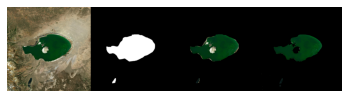

----------------
epoch[25] loss=0.19805112481117249, val_loss=0.14900293946266174, mean_iou=33.60%, val_mean_iou=0.00%
logs:  {'loss': 0.19805112481117249, 'mean_iou': 0.33597099781036377, 'val_loss': 0.14900293946266174, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.93313247
[test_ds] mean-IoU: 95.60%
[test_ds] tf-mean-IoU: 97.34%


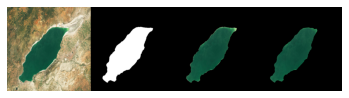

----------------
epoch[26] loss=0.19064505398273468, val_loss=0.17366325855255127, mean_iou=22.22%, val_mean_iou=0.00%
logs:  {'loss': 0.19064505398273468, 'mean_iou': 0.2222222238779068, 'val_loss': 0.17366325855255127, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.7487292
[test_ds] mean-IoU: 57.29%
[test_ds] tf-mean-IoU: 76.88%


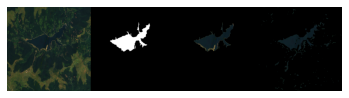

----------------
epoch[27] loss=0.22552673518657684, val_loss=0.16044634580612183, mean_iou=22.22%, val_mean_iou=100.00%
logs:  {'loss': 0.22552673518657684, 'mean_iou': 0.2222222238779068, 'val_loss': 0.16044634580612183, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.8026727
[test_ds] mean-IoU: 75.84%
[test_ds] tf-mean-IoU: 86.96%


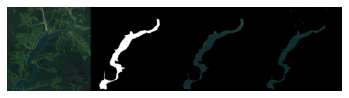

----------------
epoch[28] loss=0.15952008962631226, val_loss=0.10295972228050232, mean_iou=33.33%, val_mean_iou=100.00%
logs:  {'loss': 0.15952008962631226, 'mean_iou': 0.3333333432674408, 'val_loss': 0.10295972228050232, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9323232
[test_ds] mean-IoU: 94.99%
[test_ds] tf-mean-IoU: 96.98%


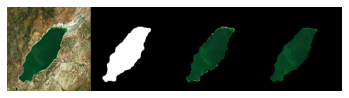

----------------
epoch[29] loss=0.17643330991268158, val_loss=0.1661405861377716, mean_iou=22.22%, val_mean_iou=0.00%
logs:  {'loss': 0.17643330991268158, 'mean_iou': 0.2222222238779068, 'val_loss': 0.1661405861377716, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9586827
[test_ds] mean-IoU: 95.64%
[test_ds] tf-mean-IoU: 97.37%


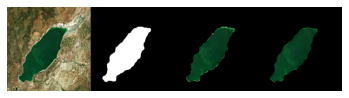

----------------
epoch[30] loss=0.1552240550518036, val_loss=0.23623940348625183, mean_iou=35.21%, val_mean_iou=100.00%
logs:  {'loss': 0.1552240550518036, 'mean_iou': 0.3520923852920532, 'val_loss': 0.23623940348625183, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9872486
[test_ds] mean-IoU: 49.59%
[test_ds] tf-mean-IoU: 72.82%


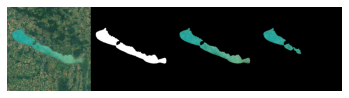

----------------
epoch[31] loss=0.24171249568462372, val_loss=0.1743631511926651, mean_iou=53.33%, val_mean_iou=100.00%
logs:  {'loss': 0.24171249568462372, 'mean_iou': 0.5332764387130737, 'val_loss': 0.1743631511926651, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9137964
[test_ds] mean-IoU: 75.30%
[test_ds] tf-mean-IoU: 85.09%


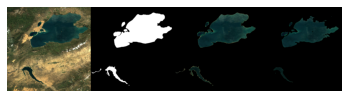

----------------
epoch[32] loss=0.15986968576908112, val_loss=0.13964413106441498, mean_iou=33.33%, val_mean_iou=100.00%
logs:  {'loss': 0.15986968576908112, 'mean_iou': 0.3333333432674408, 'val_loss': 0.13964413106441498, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.92388755
[test_ds] mean-IoU: 86.83%
[test_ds] tf-mean-IoU: 92.52%


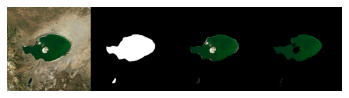

----------------
epoch[33] loss=0.1730872094631195, val_loss=0.14077439904212952, mean_iou=45.19%, val_mean_iou=100.00%
logs:  {'loss': 0.1730872094631195, 'mean_iou': 0.45185184478759766, 'val_loss': 0.14077439904212952, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.66432124
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.30%


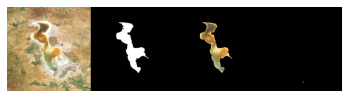

----------------
epoch[34] loss=0.17119482159614563, val_loss=0.14179274439811707, mean_iou=33.33%, val_mean_iou=100.00%
logs:  {'loss': 0.17119482159614563, 'mean_iou': 0.3333333432674408, 'val_loss': 0.14179274439811707, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9748948
[test_ds] mean-IoU: 95.31%
[test_ds] tf-mean-IoU: 97.16%


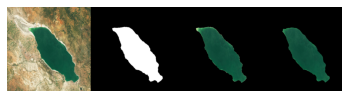

----------------
epoch[35] loss=0.14639896154403687, val_loss=0.16598616540431976, mean_iou=44.44%, val_mean_iou=100.00%
logs:  {'loss': 0.14639896154403687, 'mean_iou': 0.4444444477558136, 'val_loss': 0.16598616540431976, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9743604
[test_ds] mean-IoU: 94.53%
[test_ds] tf-mean-IoU: 96.69%


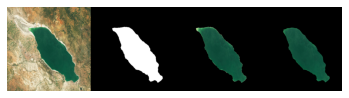

----------------
epoch[36] loss=0.20747680962085724, val_loss=0.13890263438224792, mean_iou=42.66%, val_mean_iou=100.00%
logs:  {'loss': 0.20747680962085724, 'mean_iou': 0.42660820484161377, 'val_loss': 0.13890263438224792, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.84311914
[test_ds] mean-IoU: 64.02%
[test_ds] tf-mean-IoU: 80.78%


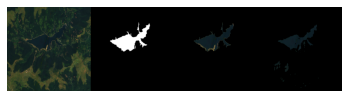

----------------
epoch[37] loss=0.14323635399341583, val_loss=0.10414180159568787, mean_iou=43.14%, val_mean_iou=100.00%
logs:  {'loss': 0.14323635399341583, 'mean_iou': 0.4313904047012329, 'val_loss': 0.10414180159568787, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.28915796
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 48.48%


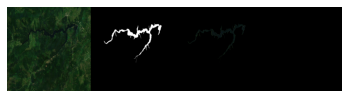

----------------
epoch[38] loss=0.12744402885437012, val_loss=0.1201968789100647, mean_iou=30.63%, val_mean_iou=0.00%
logs:  {'loss': 0.12744402885437012, 'mean_iou': 0.3062865436077118, 'val_loss': 0.1201968789100647, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9122599
[test_ds] mean-IoU: 71.26%
[test_ds] tf-mean-IoU: 84.75%


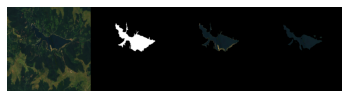

----------------
epoch[39] loss=0.15427443385124207, val_loss=0.15416496992111206, mean_iou=67.97%, val_mean_iou=0.00%
logs:  {'loss': 0.15427443385124207, 'mean_iou': 0.6797385811805725, 'val_loss': 0.15416496992111206, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.8798374
[test_ds] mean-IoU: 40.80%
[test_ds] tf-mean-IoU: 69.46%


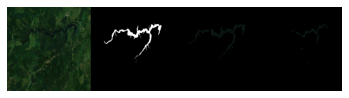

----------------
epoch[40] loss=0.1488286852836609, val_loss=0.18357595801353455, mean_iou=45.03%, val_mean_iou=100.00%
logs:  {'loss': 0.1488286852836609, 'mean_iou': 0.4502923786640167, 'val_loss': 0.18357595801353455, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.70461756
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.30%


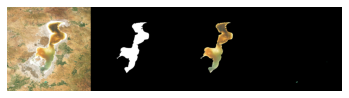

----------------
epoch[41] loss=0.19480237364768982, val_loss=0.14445149898529053, mean_iou=74.07%, val_mean_iou=100.00%
logs:  {'loss': 0.19480237364768982, 'mean_iou': 0.7407407760620117, 'val_loss': 0.14445149898529053, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.7124518
[test_ds] mean-IoU: 1.93%
[test_ds] tf-mean-IoU: 49.47%


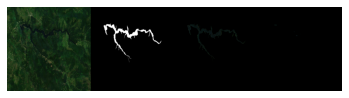

----------------
epoch[42] loss=0.13682614266872406, val_loss=0.14775872230529785, mean_iou=78.70%, val_mean_iou=100.00%
logs:  {'loss': 0.13682614266872406, 'mean_iou': 0.7870370745658875, 'val_loss': 0.14775872230529785, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.98630166
[test_ds] mean-IoU: 93.33%
[test_ds] tf-mean-IoU: 95.95%


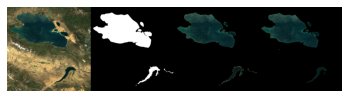

----------------
epoch[43] loss=0.1097344309091568, val_loss=0.1703895628452301, mean_iou=57.99%, val_mean_iou=100.00%
logs:  {'loss': 0.1097344309091568, 'mean_iou': 0.5799102187156677, 'val_loss': 0.1703895628452301, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9919154
[test_ds] mean-IoU: 94.79%
[test_ds] tf-mean-IoU: 96.83%


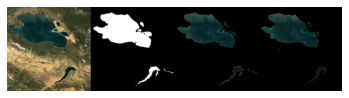

----------------
epoch[44] loss=0.16218051314353943, val_loss=0.11750828474760056, mean_iou=48.61%, val_mean_iou=100.00%
logs:  {'loss': 0.16218051314353943, 'mean_iou': 0.4861111044883728, 'val_loss': 0.11750828474760056, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.8316445
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.30%


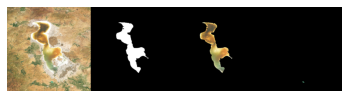

----------------
epoch[45] loss=0.11036226898431778, val_loss=0.11095836758613586, mean_iou=68.63%, val_mean_iou=100.00%
logs:  {'loss': 0.11036226898431778, 'mean_iou': 0.686274528503418, 'val_loss': 0.11095836758613586, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99352986
[test_ds] mean-IoU: 95.95%
[test_ds] tf-mean-IoU: 97.56%


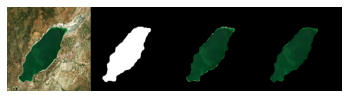

----------------
epoch[46] loss=0.16806644201278687, val_loss=0.10395292192697525, mean_iou=66.67%, val_mean_iou=100.00%
logs:  {'loss': 0.16806644201278687, 'mean_iou': 0.6666666865348816, 'val_loss': 0.10395292192697525, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.98930454
[test_ds] mean-IoU: 96.02%
[test_ds] tf-mean-IoU: 97.59%


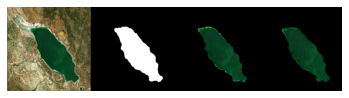

----------------
epoch[47] loss=0.11649660021066666, val_loss=0.33074867725372314, mean_iou=77.78%, val_mean_iou=0.00%
logs:  {'loss': 0.11649660021066666, 'mean_iou': 0.7777777910232544, 'val_loss': 0.33074867725372314, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99868923
[test_ds] mean-IoU: 73.49%
[test_ds] tf-mean-IoU: 82.91%


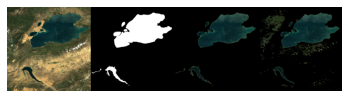

----------------
epoch[48] loss=0.13072973489761353, val_loss=0.1502837985754013, mean_iou=75.10%, val_mean_iou=0.00%
logs:  {'loss': 0.13072973489761353, 'mean_iou': 0.7509920597076416, 'val_loss': 0.1502837985754013, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9414177
[test_ds] mean-IoU: 48.01%
[test_ds] tf-mean-IoU: 71.34%


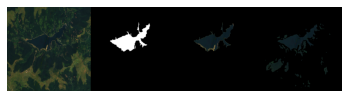

----------------
epoch[49] loss=0.1279584914445877, val_loss=0.13125662505626678, mean_iou=55.56%, val_mean_iou=100.00%
logs:  {'loss': 0.1279584914445877, 'mean_iou': 0.5555555820465088, 'val_loss': 0.13125662505626678, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9997441
[test_ds] mean-IoU: 59.60%
[test_ds] tf-mean-IoU: 77.30%


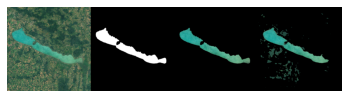

----------------
epoch[50] loss=0.1434391736984253, val_loss=0.1860204041004181, mean_iou=77.78%, val_mean_iou=0.00%
logs:  {'loss': 0.1434391736984253, 'mean_iou': 0.7777777910232544, 'val_loss': 0.1860204041004181, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99916184
[test_ds] mean-IoU: 97.46%
[test_ds] tf-mean-IoU: 98.46%


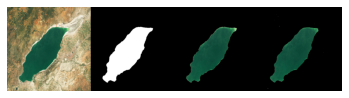

----------------
epoch[51] loss=0.0979730561375618, val_loss=0.12166003882884979, mean_iou=41.36%, val_mean_iou=100.00%
logs:  {'loss': 0.0979730561375618, 'mean_iou': 0.4135802686214447, 'val_loss': 0.12166003882884979, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9981382
[test_ds] mean-IoU: 96.38%
[test_ds] tf-mean-IoU: 97.81%


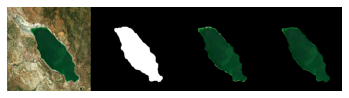

----------------
epoch[52] loss=0.22839249670505524, val_loss=0.12965060770511627, mean_iou=55.56%, val_mean_iou=100.00%
logs:  {'loss': 0.22839249670505524, 'mean_iou': 0.5555555820465088, 'val_loss': 0.12965060770511627, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.98961544
[test_ds] mean-IoU: 88.69%
[test_ds] tf-mean-IoU: 93.57%


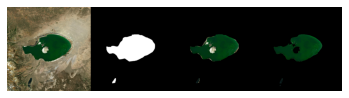

----------------
epoch[53] loss=0.12201416492462158, val_loss=0.10519212484359741, mean_iou=66.67%, val_mean_iou=100.00%
logs:  {'loss': 0.12201416492462158, 'mean_iou': 0.6666666865348816, 'val_loss': 0.10519212484359741, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.87196565
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.30%


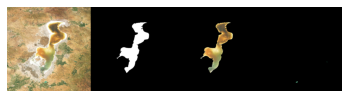

----------------
epoch[54] loss=0.11609408259391785, val_loss=0.12879693508148193, mean_iou=68.01%, val_mean_iou=100.00%
logs:  {'loss': 0.11609408259391785, 'mean_iou': 0.680134654045105, 'val_loss': 0.12879693508148193, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9736104
[test_ds] mean-IoU: 65.42%
[test_ds] tf-mean-IoU: 80.96%


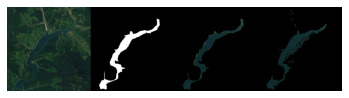

----------------
epoch[55] loss=0.10237464308738708, val_loss=0.10476809740066528, mean_iou=75.31%, val_mean_iou=100.00%
logs:  {'loss': 0.10237464308738708, 'mean_iou': 0.7530863881111145, 'val_loss': 0.10476809740066528, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9949197
[test_ds] mean-IoU: 91.72%
[test_ds] tf-mean-IoU: 94.97%


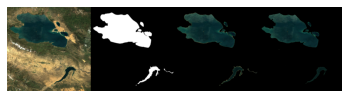

----------------
epoch[56] loss=0.1374686062335968, val_loss=0.1405787318944931, mean_iou=55.56%, val_mean_iou=100.00%
logs:  {'loss': 0.1374686062335968, 'mean_iou': 0.5555555820465088, 'val_loss': 0.1405787318944931, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9828553
[test_ds] mean-IoU: 50.66%
[test_ds] tf-mean-IoU: 72.02%


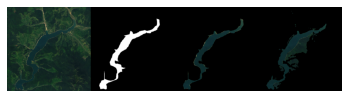

----------------
epoch[57] loss=0.11335840821266174, val_loss=0.12409789860248566, mean_iou=55.56%, val_mean_iou=100.00%
logs:  {'loss': 0.11335840821266174, 'mean_iou': 0.5555555820465088, 'val_loss': 0.12409789860248566, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9984059
[test_ds] mean-IoU: 96.74%
[test_ds] tf-mean-IoU: 98.03%


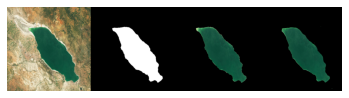

----------------
epoch[58] loss=0.12841880321502686, val_loss=0.13011673092842102, mean_iou=72.22%, val_mean_iou=100.00%
logs:  {'loss': 0.12841880321502686, 'mean_iou': 0.7222222089767456, 'val_loss': 0.13011673092842102, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9939592
[test_ds] mean-IoU: 92.24%
[test_ds] tf-mean-IoU: 95.28%


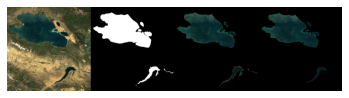

----------------
epoch[59] loss=0.10429076105356216, val_loss=0.11055703461170197, mean_iou=66.67%, val_mean_iou=100.00%
logs:  {'loss': 0.10429076105356216, 'mean_iou': 0.6666666865348816, 'val_loss': 0.11055703461170197, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.41912478
[test_ds] mean-IoU: 0.08%
[test_ds] tf-mean-IoU: 48.51%


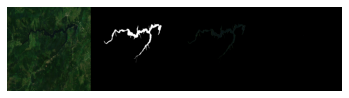

----------------
epoch[60] loss=0.14478108286857605, val_loss=0.13359643518924713, mean_iou=55.56%, val_mean_iou=100.00%
logs:  {'loss': 0.14478108286857605, 'mean_iou': 0.5555555820465088, 'val_loss': 0.13359643518924713, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.98979527
[test_ds] mean-IoU: 87.34%
[test_ds] tf-mean-IoU: 92.81%


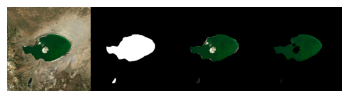

----------------
epoch[61] loss=0.11372119933366776, val_loss=0.11195451021194458, mean_iou=82.10%, val_mean_iou=100.00%
logs:  {'loss': 0.11372119933366776, 'mean_iou': 0.8209876418113708, 'val_loss': 0.11195451021194458, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.999798
[test_ds] mean-IoU: 86.18%
[test_ds] tf-mean-IoU: 92.50%


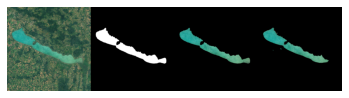

----------------
epoch[62] loss=0.08957306295633316, val_loss=0.12352217733860016, mean_iou=66.67%, val_mean_iou=100.00%
logs:  {'loss': 0.08957306295633316, 'mean_iou': 0.6666666865348816, 'val_loss': 0.12352217733860016, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9989374
[test_ds] mean-IoU: 96.20%
[test_ds] tf-mean-IoU: 97.70%


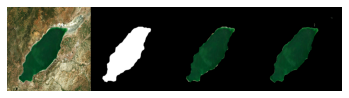

----------------
epoch[63] loss=0.09528175741434097, val_loss=0.13190129399299622, mean_iou=68.89%, val_mean_iou=100.00%
logs:  {'loss': 0.09528175741434097, 'mean_iou': 0.6888888478279114, 'val_loss': 0.13190129399299622, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99979573
[test_ds] mean-IoU: 96.09%
[test_ds] tf-mean-IoU: 97.62%


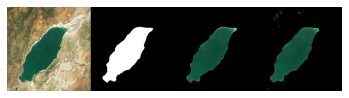

----------------
epoch[64] loss=0.18942680954933167, val_loss=0.16619972884655, mean_iou=41.98%, val_mean_iou=0.00%
logs:  {'loss': 0.18942680954933167, 'mean_iou': 0.4197530746459961, 'val_loss': 0.16619972884655, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99646854
[test_ds] mean-IoU: 95.91%
[test_ds] tf-mean-IoU: 97.53%


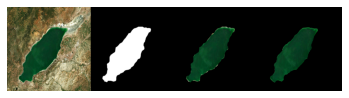

----------------
epoch[65] loss=0.09864123165607452, val_loss=0.23181481659412384, mean_iou=66.67%, val_mean_iou=0.00%
logs:  {'loss': 0.09864123165607452, 'mean_iou': 0.6666666865348816, 'val_loss': 0.23181481659412384, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99999917
[test_ds] mean-IoU: 91.57%
[test_ds] tf-mean-IoU: 94.82%


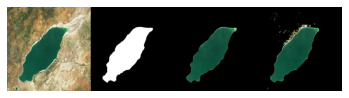

----------------
epoch[66] loss=0.1120554506778717, val_loss=0.1310862898826599, mean_iou=55.56%, val_mean_iou=100.00%
logs:  {'loss': 0.1120554506778717, 'mean_iou': 0.5555555820465088, 'val_loss': 0.1310862898826599, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9969844
[test_ds] mean-IoU: 89.46%
[test_ds] tf-mean-IoU: 94.00%


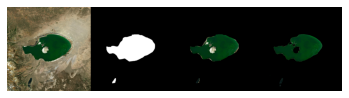

----------------
epoch[67] loss=0.08681555092334747, val_loss=0.18627279996871948, mean_iou=88.89%, val_mean_iou=100.00%
logs:  {'loss': 0.08681555092334747, 'mean_iou': 0.8888888955116272, 'val_loss': 0.18627279996871948, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9469185
[test_ds] mean-IoU: 42.96%
[test_ds] tf-mean-IoU: 70.49%


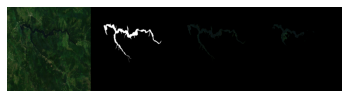

----------------
epoch[68] loss=0.11248370260000229, val_loss=0.15028737485408783, mean_iou=66.67%, val_mean_iou=100.00%
logs:  {'loss': 0.11248370260000229, 'mean_iou': 0.6666666865348816, 'val_loss': 0.15028737485408783, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9489193
[test_ds] mean-IoU: 40.89%
[test_ds] tf-mean-IoU: 69.52%


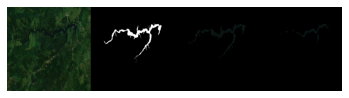

----------------
epoch[69] loss=0.1026870533823967, val_loss=0.1241363063454628, mean_iou=77.78%, val_mean_iou=100.00%
logs:  {'loss': 0.1026870533823967, 'mean_iou': 0.7777777910232544, 'val_loss': 0.1241363063454628, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9986848
[test_ds] mean-IoU: 94.47%
[test_ds] tf-mean-IoU: 96.63%


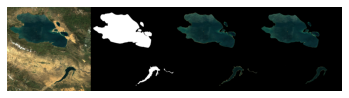

----------------
epoch[70] loss=0.10891230404376984, val_loss=0.34037458896636963, mean_iou=66.67%, val_mean_iou=0.00%
logs:  {'loss': 0.10891230404376984, 'mean_iou': 0.6666666865348816, 'val_loss': 0.34037458896636963, 'val_mean_iou': 0.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99213845
[test_ds] mean-IoU: 15.05%
[test_ds] tf-mean-IoU: 41.58%


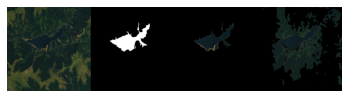

----------------
epoch[71] loss=0.13143979012966156, val_loss=0.08588656038045883, mean_iou=55.56%, val_mean_iou=100.00%
logs:  {'loss': 0.13143979012966156, 'mean_iou': 0.5555555820465088, 'val_loss': 0.08588656038045883, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.90086734
[test_ds] mean-IoU: 8.96%
[test_ds] tf-mean-IoU: 53.05%


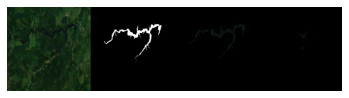

----------------
epoch[72] loss=0.080342598259449, val_loss=0.09341973066329956, mean_iou=77.78%, val_mean_iou=100.00%
logs:  {'loss': 0.080342598259449, 'mean_iou': 0.7777777910232544, 'val_loss': 0.09341973066329956, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99926215
[test_ds] mean-IoU: 96.38%
[test_ds] tf-mean-IoU: 97.81%


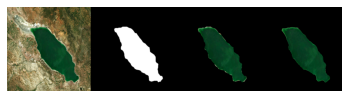

----------------
epoch[73] loss=0.13045376539230347, val_loss=0.10238926112651825, mean_iou=66.67%, val_mean_iou=100.00%
logs:  {'loss': 0.13045376539230347, 'mean_iou': 0.6666666865348816, 'val_loss': 0.10238926112651825, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.8709491
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.30%


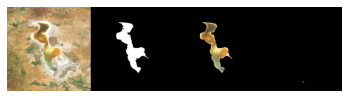

----------------
epoch[74] loss=0.07976365089416504, val_loss=0.09704478085041046, mean_iou=66.67%, val_mean_iou=100.00%
logs:  {'loss': 0.07976365089416504, 'mean_iou': 0.6666666865348816, 'val_loss': 0.09704478085041046, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.85582983
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.30%


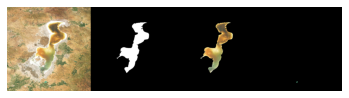

----------------
epoch[75] loss=0.12266262620687485, val_loss=0.14496296644210815, mean_iou=64.14%, val_mean_iou=100.00%
logs:  {'loss': 0.12266262620687485, 'mean_iou': 0.6414141058921814, 'val_loss': 0.14496296644210815, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.5945454
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.31%


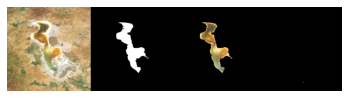

----------------
epoch[76] loss=0.08853510022163391, val_loss=0.08863656222820282, mean_iou=55.56%, val_mean_iou=100.00%
logs:  {'loss': 0.08853510022163391, 'mean_iou': 0.5555555820465088, 'val_loss': 0.08863656222820282, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.22769059
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.31%


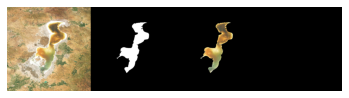

----------------
epoch[77] loss=0.08970021456480026, val_loss=0.17045751214027405, mean_iou=95.30%, val_mean_iou=100.00%
logs:  {'loss': 0.08970021456480026, 'mean_iou': 0.9529914855957031, 'val_loss': 0.17045751214027405, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999758
[test_ds] mean-IoU: 97.89%
[test_ds] tf-mean-IoU: 98.72%


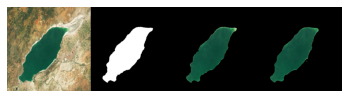

----------------
epoch[78] loss=0.0920616015791893, val_loss=0.08570617437362671, mean_iou=77.78%, val_mean_iou=100.00%
logs:  {'loss': 0.0920616015791893, 'mean_iou': 0.7777777910232544, 'val_loss': 0.08570617437362671, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99888283
[test_ds] mean-IoU: 94.80%
[test_ds] tf-mean-IoU: 96.84%


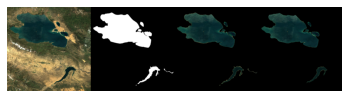

----------------
epoch[79] loss=0.08079270273447037, val_loss=0.14394818246364594, mean_iou=68.35%, val_mean_iou=100.00%
logs:  {'loss': 0.08079270273447037, 'mean_iou': 0.683501660823822, 'val_loss': 0.14394818246364594, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  1.0
[test_ds] mean-IoU: 85.96%
[test_ds] tf-mean-IoU: 91.30%


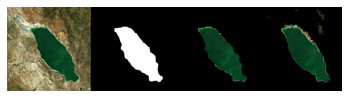

----------------
epoch[80] loss=0.09872237592935562, val_loss=0.10444889962673187, mean_iou=55.56%, val_mean_iou=100.00%
logs:  {'loss': 0.09872237592935562, 'mean_iou': 0.5555555820465088, 'val_loss': 0.10444889962673187, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9997944
[test_ds] mean-IoU: 96.27%
[test_ds] tf-mean-IoU: 97.74%


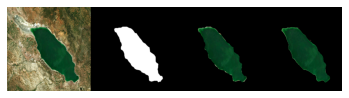

----------------
epoch[81] loss=0.07110616564750671, val_loss=0.09379688650369644, mean_iou=67.68%, val_mean_iou=100.00%
logs:  {'loss': 0.07110616564750671, 'mean_iou': 0.6767676472663879, 'val_loss': 0.09379688650369644, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999869
[test_ds] mean-IoU: 82.17%
[test_ds] tf-mean-IoU: 90.25%


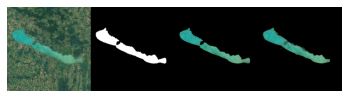

----------------
epoch[82] loss=0.15308047831058502, val_loss=0.11718668788671494, mean_iou=71.49%, val_mean_iou=100.00%
logs:  {'loss': 0.15308047831058502, 'mean_iou': 0.7149122953414917, 'val_loss': 0.11718668788671494, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.8524734
[test_ds] mean-IoU: 0.00%
[test_ds] tf-mean-IoU: 46.30%


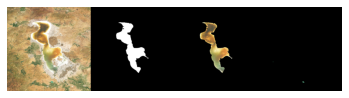

----------------
epoch[83] loss=0.08349286019802094, val_loss=0.09180735051631927, mean_iou=77.78%, val_mean_iou=100.00%
logs:  {'loss': 0.08349286019802094, 'mean_iou': 0.7777777910232544, 'val_loss': 0.09180735051631927, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9623835
[test_ds] mean-IoU: 72.24%
[test_ds] tf-mean-IoU: 85.25%


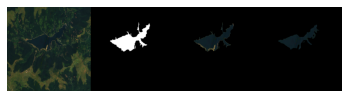

----------------
epoch[84] loss=0.07982399314641953, val_loss=0.08433520793914795, mean_iou=100.00%, val_mean_iou=100.00%
logs:  {'loss': 0.07982399314641953, 'mean_iou': 1.0, 'val_loss': 0.08433520793914795, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99801755
[test_ds] mean-IoU: 96.31%
[test_ds] tf-mean-IoU: 97.77%


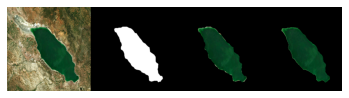

----------------
epoch[85] loss=0.06254539638757706, val_loss=0.09241975098848343, mean_iou=55.56%, val_mean_iou=100.00%
logs:  {'loss': 0.06254539638757706, 'mean_iou': 0.5555555820465088, 'val_loss': 0.09241975098848343, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99258363
[test_ds] mean-IoU: 68.64%
[test_ds] tf-mean-IoU: 82.81%


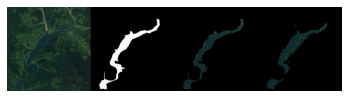

----------------
epoch[86] loss=0.10753433406352997, val_loss=0.1212952733039856, mean_iou=72.26%, val_mean_iou=100.00%
logs:  {'loss': 0.10753433406352997, 'mean_iou': 0.7225529551506042, 'val_loss': 0.1212952733039856, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9817394
[test_ds] mean-IoU: 73.41%
[test_ds] tf-mean-IoU: 85.55%


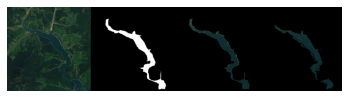

----------------
epoch[87] loss=0.0686267539858818, val_loss=0.10727554559707642, mean_iou=70.99%, val_mean_iou=100.00%
logs:  {'loss': 0.0686267539858818, 'mean_iou': 0.709876537322998, 'val_loss': 0.10727554559707642, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999336
[test_ds] mean-IoU: 82.56%
[test_ds] tf-mean-IoU: 90.47%


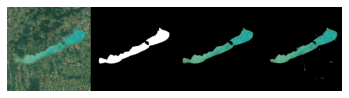

----------------
epoch[88] loss=0.09629569947719574, val_loss=0.10871335864067078, mean_iou=83.33%, val_mean_iou=100.00%
logs:  {'loss': 0.09629569947719574, 'mean_iou': 0.8333333134651184, 'val_loss': 0.10871335864067078, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.95317954
[test_ds] mean-IoU: 36.03%
[test_ds] tf-mean-IoU: 66.66%


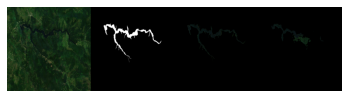

----------------
epoch[89] loss=0.05827762186527252, val_loss=0.09732811152935028, mean_iou=66.67%, val_mean_iou=100.00%
logs:  {'loss': 0.05827762186527252, 'mean_iou': 0.6666666865348816, 'val_loss': 0.09732811152935028, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.97929734
[test_ds] mean-IoU: 76.30%
[test_ds] tf-mean-IoU: 87.41%


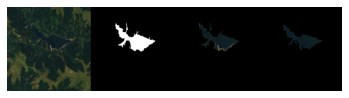

----------------
epoch[90] loss=0.08365277945995331, val_loss=0.10671781748533249, mean_iou=88.89%, val_mean_iou=100.00%
logs:  {'loss': 0.08365277945995331, 'mean_iou': 0.8888888955116272, 'val_loss': 0.10671781748533249, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.8690532
[test_ds] mean-IoU: 0.96%
[test_ds] tf-mean-IoU: 46.81%


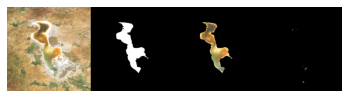

----------------
epoch[91] loss=0.06758177280426025, val_loss=0.11379075050354004, mean_iou=81.68%, val_mean_iou=100.00%
logs:  {'loss': 0.06758177280426025, 'mean_iou': 0.8168168067932129, 'val_loss': 0.11379075050354004, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9996489
[test_ds] mean-IoU: 97.73%
[test_ds] tf-mean-IoU: 98.63%


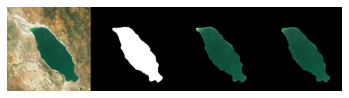

----------------
epoch[92] loss=0.06907601654529572, val_loss=0.11717068403959274, mean_iou=55.56%, val_mean_iou=100.00%
logs:  {'loss': 0.06907601654529572, 'mean_iou': 0.5555555820465088, 'val_loss': 0.11717068403959274, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9806503
[test_ds] mean-IoU: 73.90%
[test_ds] tf-mean-IoU: 86.14%


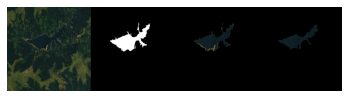

----------------
epoch[93] loss=0.08353573828935623, val_loss=0.11213696002960205, mean_iou=77.78%, val_mean_iou=100.00%
logs:  {'loss': 0.08353573828935623, 'mean_iou': 0.7777777910232544, 'val_loss': 0.11213696002960205, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99998736
[test_ds] mean-IoU: 80.94%
[test_ds] tf-mean-IoU: 89.53%


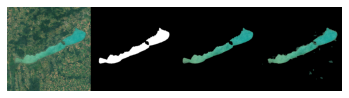

----------------
epoch[94] loss=0.09187407791614532, val_loss=0.09089246392250061, mean_iou=72.22%, val_mean_iou=100.00%
logs:  {'loss': 0.09187407791614532, 'mean_iou': 0.7222222089767456, 'val_loss': 0.09089246392250061, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99333376
[test_ds] mean-IoU: 77.25%
[test_ds] tf-mean-IoU: 87.63%


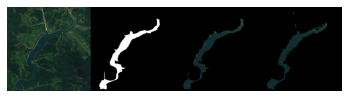

----------------
epoch[95] loss=0.05520255118608475, val_loss=0.08917894959449768, mean_iou=73.41%, val_mean_iou=100.00%
logs:  {'loss': 0.05520255118608475, 'mean_iou': 0.7341269850730896, 'val_loss': 0.08917894959449768, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.99979943
[test_ds] mean-IoU: 94.49%
[test_ds] tf-mean-IoU: 96.65%


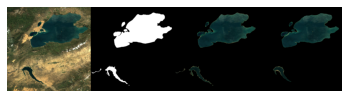

----------------
epoch[96] loss=0.11587610840797424, val_loss=0.11334899067878723, mean_iou=66.67%, val_mean_iou=100.00%
logs:  {'loss': 0.11587610840797424, 'mean_iou': 0.6666666865348816, 'val_loss': 0.11334899067878723, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9991027
[test_ds] mean-IoU: 93.66%
[test_ds] tf-mean-IoU: 96.14%


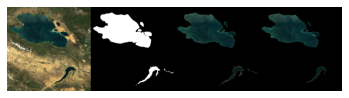

----------------
epoch[97] loss=0.058888990432024, val_loss=0.07895281165838242, mean_iou=77.78%, val_mean_iou=100.00%
logs:  {'loss': 0.058888990432024, 'mean_iou': 0.7777777910232544, 'val_loss': 0.07895281165838242, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.96805465
[test_ds] mean-IoU: 57.36%
[test_ds] tf-mean-IoU: 77.96%


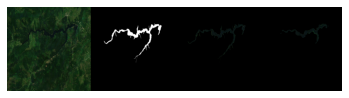

----------------
epoch[98] loss=0.04983460530638695, val_loss=0.09666908532381058, mean_iou=35.86%, val_mean_iou=100.00%
logs:  {'loss': 0.04983460530638695, 'mean_iou': 0.3585858643054962, 'val_loss': 0.09666908532381058, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9999597
[test_ds] mean-IoU: 87.50%
[test_ds] tf-mean-IoU: 93.18%


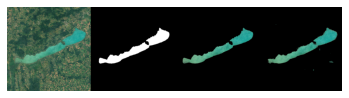

----------------
epoch[99] loss=0.0698622539639473, val_loss=0.20998498797416687, mean_iou=77.78%, val_mean_iou=100.00%
logs:  {'loss': 0.0698622539639473, 'mean_iou': 0.7777777910232544, 'val_loss': 0.20998498797416687, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  1.0
[test_ds] mean-IoU: 92.14%
[test_ds] tf-mean-IoU: 95.17%


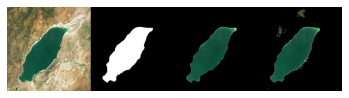

----------------
epoch[100] loss=0.0976177453994751, val_loss=0.10329490154981613, mean_iou=57.26%, val_mean_iou=100.00%
logs:  {'loss': 0.0976177453994751, 'mean_iou': 0.5726495981216431, 'val_loss': 0.10329490154981613, 'val_mean_iou': 1.0}
------- evaluate & plot ---------
pred_mask shape:  (512, 512) , max_value:  0.9619775
[test_ds] mean-IoU: 25.61%
[test_ds] tf-mean-IoU: 58.96%


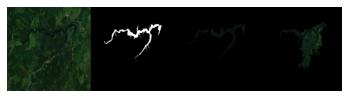

----------------
evaluate: test data set repeat count:  20
40/40 [==============================] - 23s 581ms/step - loss: 0.0839 - mean_iou: 1.0000
test loss, test acc: [0.08386785537004471, 1.0]


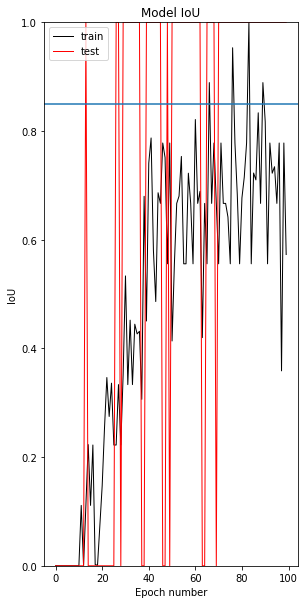

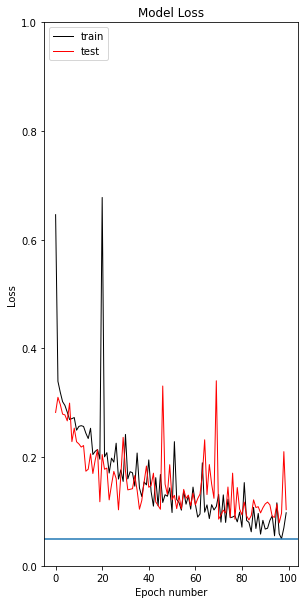

In [ ]:
train_evaluate(train_data_sets=s2_data_sets,
               test_data_sets=s2_data_sets,
               unet_h5='/content/drive/My Drive/data_sets/s2_only_unet.h5',
               image_shape=(512, 512, 3),
               num_epochs=100,
               eval_repeat_count=20,
               min_water_pixel=100)

In [ ]:
train_evaluate(train_data_sets=s2_data_sets,
               test_data_sets=s2_data_sets,
               unet_h5='/content/drive/My Drive/data_sets/s2_only_unet.h5',
               image_shape=(512, 512, 3),
               num_epochs=300,
               eval_repeat_count=20,
               min_water_pixel=60)

In [ ]:
train_evaluate(train_data_sets=data_sets,
               test_data_sets=data_sets,
               unet_h5='/content/drive/My Drive/data_sets/mixed_datasets_unet.h5',
               image_shape=(512, 512, 3),
               num_epochs=100,
               eval_repeat_count=20,
               min_water_pixel=60)

In [ ]:
train_evaluate(train_data_sets=data_sets,
               test_data_sets=data_sets,
               unet_h5='/content/drive/My Drive/data_sets/mixed_datasets_unet.h5',
               image_shape=(512, 512, 3),
               num_epochs=300,
               eval_repeat_count=20,
               min_water_pixel=60)

In [ ]:
train_evaluate(train_data_sets=data_sets,
               test_data_sets=data_sets,
               unet_h5='/content/drive/My Drive/data_sets/mixed_datasets_unet.h5',
               image_shape=(512, 512, 3),
               num_epochs=100,
               eval_repeat_count=20,
               min_water_pixel=100)

set water pixel prob:  0.390625
start training: epochs:  500 , steps: train:  7 , validation:  1 , test:  0
epoch[1] loss=0.6038618087768555, val_loss=0.46079492568969727, mean_iou=3.35%, val_mean_iou=4.77%
logs:  {'loss': 0.6038618087768555, 'mean_iou': 0.03349879011511803, 'val_loss': 0.46079492568969727, 'val_mean_iou': 0.047700170427560806}
epoch[2] loss=0.5438847541809082, val_loss=0.4932872951030731, mean_iou=4.95%, val_mean_iou=4.70%
logs:  {'loss': 0.5438847541809082, 'mean_iou': 0.04952015355229378, 'val_loss': 0.4932872951030731, 'val_mean_iou': 0.04704595357179642}
epoch[3] loss=0.4788992702960968, val_loss=0.3884793817996979, mean_iou=5.93%, val_mean_iou=26.57%
logs:  {'loss': 0.4788992702960968, 'mean_iou': 0.05931113287806511, 'val_loss': 0.3884793817996979, 'val_mean_iou': 0.2656826674938202}
epoch[4] loss=0.4770565330982208, val_loss=0.39237120747566223, mean_iou=6.06%, val_mean_iou=26.92%
logs:  {'loss': 0.4770565330982208, 'mean_iou': 0.06055396795272827, 'val_loss': 

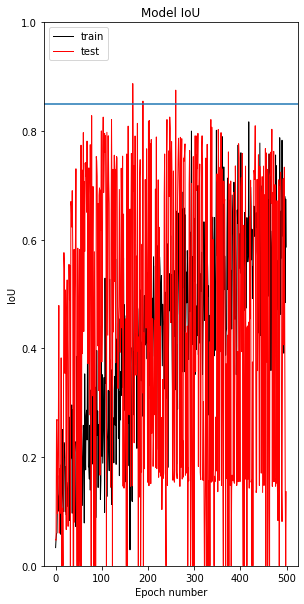

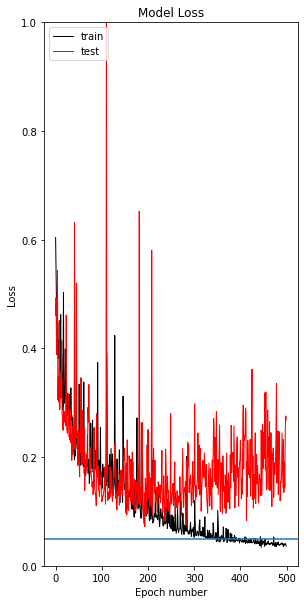

In [20]:
train_evaluate(train_data_sets=resisc_train_data_sets,
               test_data_sets=s2_test_data_256_sets,
                image_shape=(256,256,3),
               unet_h5='/content/drive/My Drive/data_sets/resisc_train_s2_test_unet.h5',
               num_epochs=500,
               eval_repeat_count=100,
               min_water_pixel=100)

In [ ]:
train_evaluate(train_data_sets=s2_train_data_sets,
               test_data_sets=resisc_test_data_512_sets,
               image_shape=(512,512,3),
               unet_h5='/content/drive/My Drive/data_sets/s2_train_resisc_test_unet.h5',
               num_epochs=200,
               eval_repeat_count=100,
               min_water_pixel=100)

In [ ]:
train_evaluate(train_data_sets=data_sets_256,
               test_data_sets=data_sets_256,
               image_shape=(256,256,3),
               unet_h5='/content/drive/My Drive/data_sets/mixed_data_sets_256_unet.h5',
               num_epochs=300,
               eval_repeat_count=100,
               min_water_pixel=60)

In [ ]:
train_evaluate(train_data_sets=data_sets_256,
               test_data_sets=data_sets_256,
               image_shape=(256,256,3),
               unet_h5='/content/drive/My Drive/data_sets/mixed_data_sets_256_wpixel100_unet.h5',
               num_epochs=300,
               eval_repeat_count=100,
               min_water_pixel=100)

In [ ]:
train_evaluate(train_data_sets=resisc_data_sets,
               test_data_sets=resisc_data_sets,
               unet_h5='/content/drive/My Drive/data_sets/resisc_only_unet.h5',
               num_epochs=500,
               eval_repeat_count=100,
               min_water_pixel=100)

In [ ]:
train_evaluate(train_data_sets=data_sets_256,
               test_data_sets=data_sets_256,
               image_shape=(256,256,3),
               unet_h5='/content/drive/My Drive/data_sets/mixed_data_sets_256_unet.h5',
               num_epochs=600,
               eval_repeat_count=100,
               min_water_pixel=100)

set water pixel prob:  0.3125
start training: epochs:  300 , steps: train:  17 , validation:  1 , test:  1
epoch[1] loss=0.7307039499282837, val_loss=0.45277243852615356, mean_iou=1.25%, val_mean_iou=4.44%
epoch[2] loss=0.398541122674942, val_loss=0.38745447993278503, mean_iou=2.80%, val_mean_iou=0.00%
epoch[3] loss=0.3664209842681885, val_loss=0.3413698375225067, mean_iou=4.64%, val_mean_iou=3.81%
epoch[4] loss=0.3457720875740051, val_loss=0.34209734201431274, mean_iou=10.34%, val_mean_iou=18.85%
epoch[5] loss=0.3296324610710144, val_loss=0.30910512804985046, mean_iou=18.61%, val_mean_iou=0.00%
epoch[6] loss=0.3140266239643097, val_loss=0.28251776099205017, mean_iou=4.28%, val_mean_iou=29.76%
epoch[7] loss=0.3712541460990906, val_loss=0.22787609696388245, mean_iou=17.90%, val_mean_iou=63.16%
epoch[8] loss=0.3456593155860901, val_loss=0.32052794098854065, mean_iou=12.65%, val_mean_iou=0.00%
epoch[9] loss=0.26525670289993286, val_loss=0.2439241260290146, mean_iou=15.86%, val_mean_iou=0.

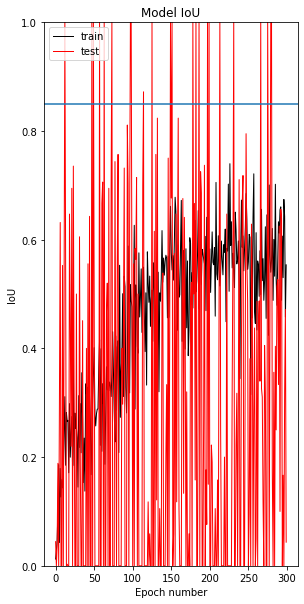

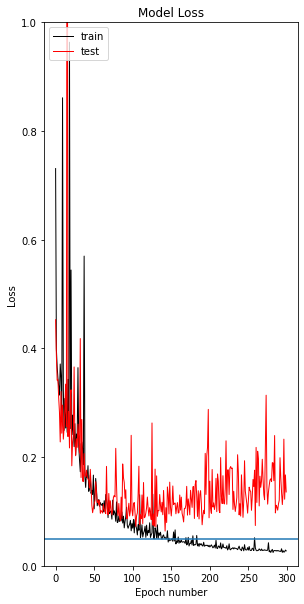

In [19]:
train_evaluate(train_data_sets=data_sets_256,
               test_data_sets=data_sets_256,
               image_shape=(256,256,3),
               unet_h5='/content/drive/My Drive/data_sets/mixed_data_sets_256_unet.h5',
               num_epochs=300,
               eval_repeat_count=100,
               min_water_pixel=80)

set water pixel prob:  0.3515625
start training: epochs:  300 , steps: train:  6 , validation:  1 , test:  1
epoch[1] loss=0.684222936630249, val_loss=0.614746630191803, mean_iou=2.41%, val_mean_iou=1.20%
epoch[2] loss=0.545444905757904, val_loss=0.5615469217300415, mean_iou=4.45%, val_mean_iou=2.13%
epoch[3] loss=0.434214323759079, val_loss=0.5386662483215332, mean_iou=1.95%, val_mean_iou=4.05%
epoch[4] loss=0.47537633776664734, val_loss=0.5503474473953247, mean_iou=15.75%, val_mean_iou=2.35%
epoch[5] loss=0.4296048879623413, val_loss=0.5252640247344971, mean_iou=11.11%, val_mean_iou=0.99%
epoch[6] loss=0.43488773703575134, val_loss=0.5277889966964722, mean_iou=13.27%, val_mean_iou=1.40%
epoch[7] loss=0.4357281029224396, val_loss=0.5050137639045715, mean_iou=7.14%, val_mean_iou=1.23%
epoch[8] loss=0.4173773527145386, val_loss=0.501343846321106, mean_iou=6.60%, val_mean_iou=0.87%
epoch[9] loss=0.38117000460624695, val_loss=0.4912642240524292, mean_iou=1.51%, val_mean_iou=1.95%
epoch[10

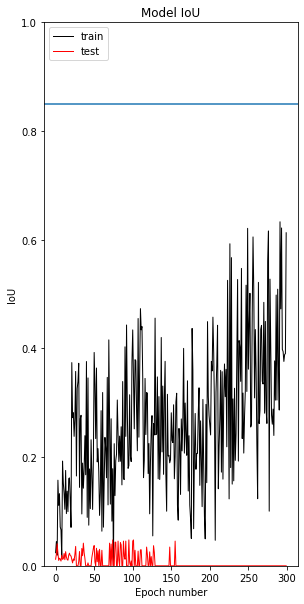

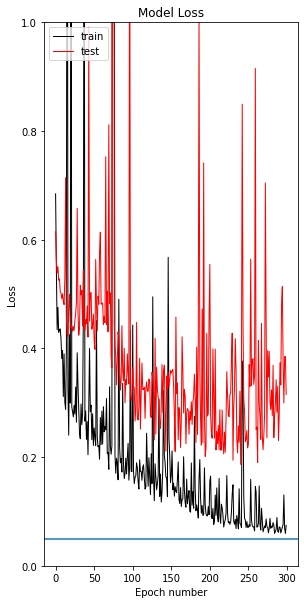

In [20]:
train_evaluate(train_data_sets=resisc_data_sets,
               test_data_sets=resisc_data_sets,
               unet_h5='/content/drive/My Drive/data_sets/resisc_only_unet.h5',
               num_epochs=300,
               eval_repeat_count=100,
               min_water_pixel=90)

In [ ]:
train_evaluate(train_data_sets=resisc_data_sets,
               test_data_sets=resisc_data_sets,
               unet_h5='/content/drive/My Drive/data_sets/resisc_only_unet.h5',
               num_epochs=700,
               eval_repeat_count=100,
               min_water_pixel=100)